In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import matplotlib as mpl
import mplhep
import sys

sys.path.append("../../analysisTools/")
import plotTools as ptools

### Cut-based

In [218]:
prefix = '../SR_Cut-based/coffea/skimmed/'
suffix = '_SR_v3_skimmed'

# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD after OSSF cut
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

In [219]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
print(sig_samples)

['sig_2018_Mchi-5p5_dMchi-1p0_ctau-10', 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-100', 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-1', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-100', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-10', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-1', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-100', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-10', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-1', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1', 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-100', 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-100', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-10', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-1', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-10

In [220]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
print(cuts)

['all', 'hasVtx', 'cut5', 'cut6', 'cut7', 'cut8', 'cut9', 'cut10', 'cut11', 'cut12', 'cut13', 'cut14', 'cut15']


In [221]:
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

print(si)

                                         mchi  dmchi   ctau    m1    m2  \
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10      5.50    1.0   10.0   5.0   6.0   
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100     5.50    1.0  100.0   5.0   6.0   
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1       5.50    1.0    1.0   5.0   6.0   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100    5.25    0.5  100.0   5.0   5.5   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10     5.25    0.5   10.0   5.0   5.5   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1      5.25    0.5    1.0   5.0   5.5   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100  55.00   10.0  100.0  50.0  60.0   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10   55.00   10.0   10.0  50.0  60.0   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1    55.00   10.0    1.0  50.0  60.0   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10    52.50    5.0   10.0  50.0  55.0   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100   52.50    5.0  100.0  50.0  55.0   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1     52.50    5.0    1.0  50.0  55.0   
sig_2018_Mchi-44p0_dMchi-

In [222]:
deltas = sorted(list(set(si.delta)))
m1s = sorted(list(set(si.m1)))
all_ctaus = sorted(list(set(si.ctau)))

In [223]:
bkg = {}

for h in histograms:
    bkg[h] = {}
    for b in bkg_histos.keys():
        if type(bkg_histos[b][h]) == hist.Hist and bkg_histos[b][h].sum(flow=True).value > 0:
            bkg[h][b] = bkg_histos[b][h][{"samp":sum}]

def plot_bkg(hname, cut, rebin=1j, doLog=True, xlim = [], title='', doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    plt.title(title)
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

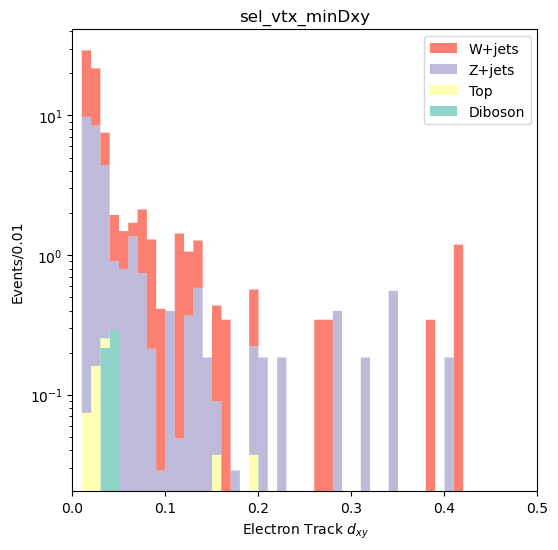

In [224]:
plot_bkg('sel_vtx_minDxy', 'cut15', xlim = [0, 0.5], title='sel_vtx_minDxy', rebin=1j)

In [225]:
def plot_sig(hname, cut, delta, m1, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
    hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
    mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

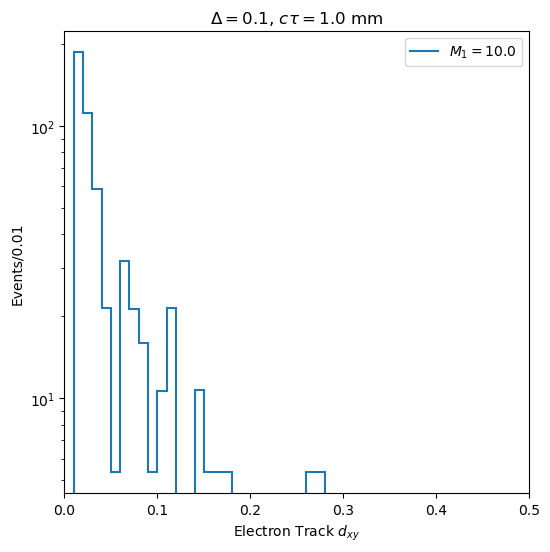

In [226]:
delta = deltas[0]
m1 = m1s[1]
ct = all_ctaus[0]

plot_sig('sel_vtx_minDxy', cut='cut15', xlim = [0, 0.5], delta=delta, m1=m1, ct=ct)

In [227]:
def plot_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

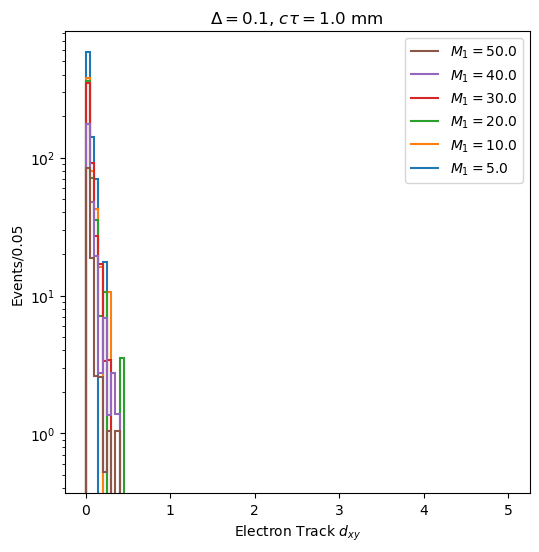

In [228]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, rebin=5j)

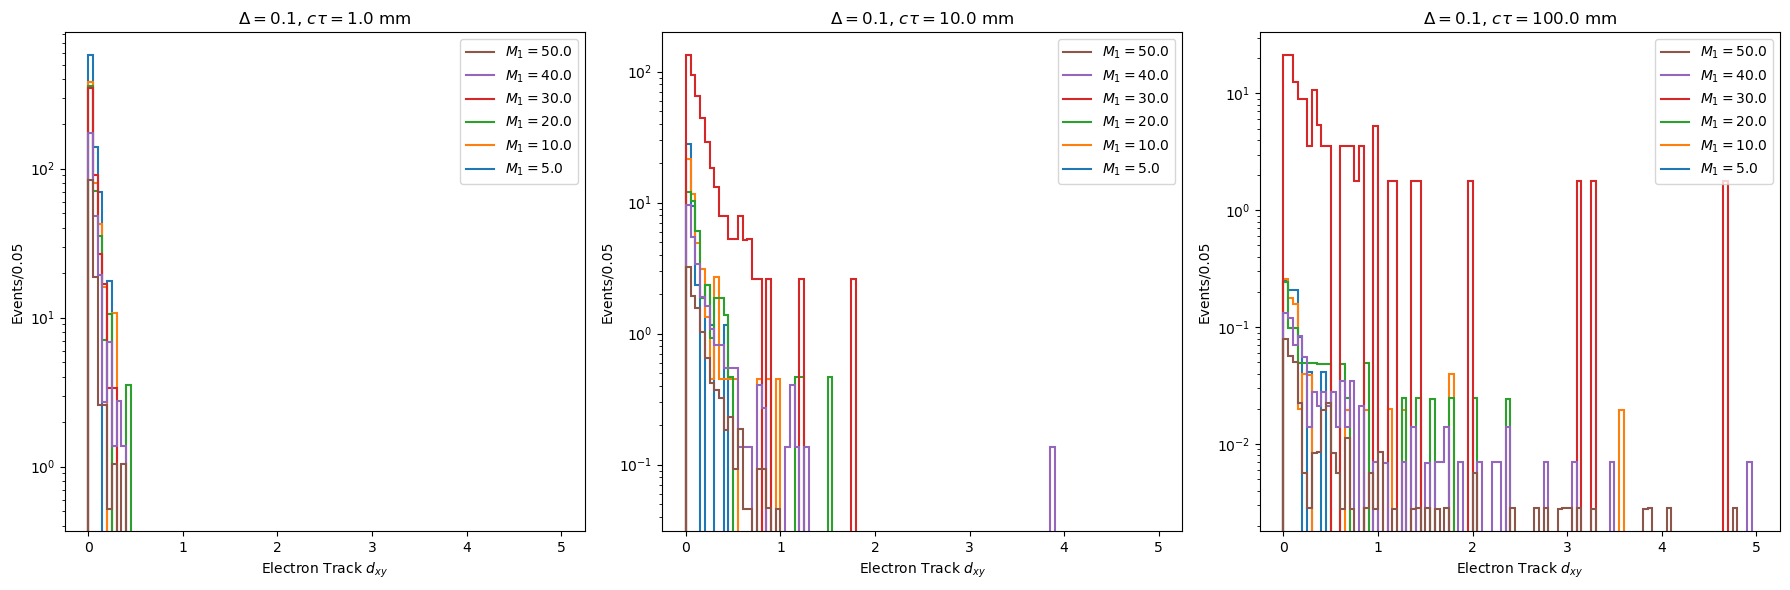

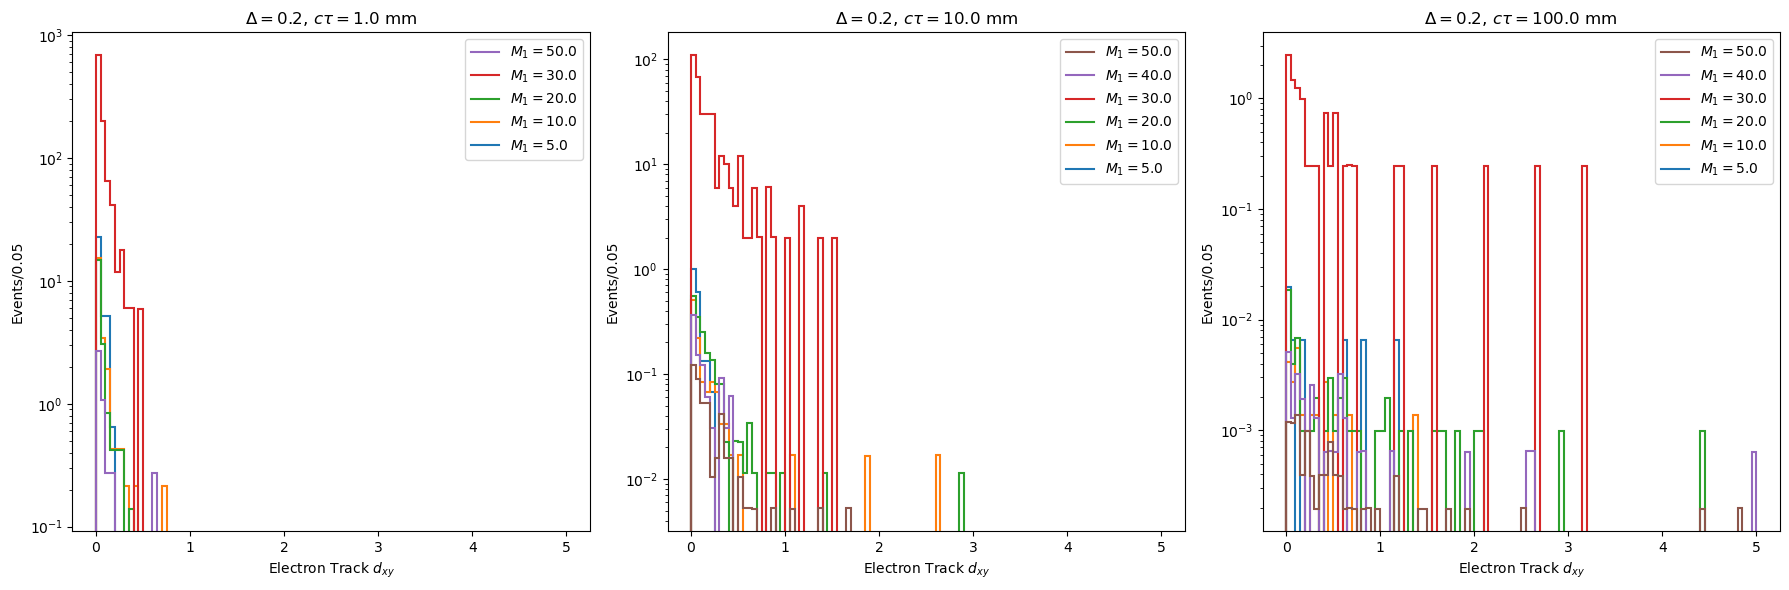

In [229]:
for delta in deltas:
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    
    for i, ct in enumerate(ctaus):
        plot_sig_varying_M1(axes[i], 'sel_vtx_minDxy', 'cut15', delta, ct, rebin=5j )
        #plt.savefig(f'plots/cutflow/efficiency_delta_{delta}.png')
    plt.tight_layout()
    plt.show()

In [230]:
def plot_bkg_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], xlabel='', flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):    
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    # bkg
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    # signal
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    #plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel('Events/{:.2f}'.format(binwidth))

    if xlabel != '':
        plt.xlabel(xlabel)
    
    if doLog:
        plt.yscale('log')
    plt.legend()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')

    if xlim != []:
        plt.xlim(xlim)
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

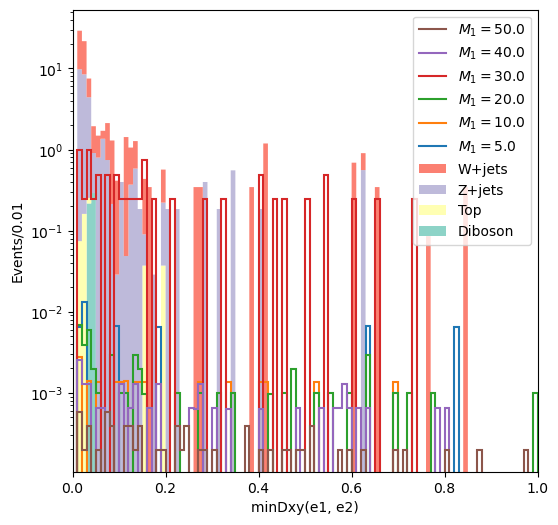

In [231]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, rebin=1j, xlim=[0,1], xlabel = 'minDxy(e1, e2)', doLog=True)

'sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif'

### 'sel_vtx_sign'

Text(0.5, 1.0, 'Cut-based: ctau = 1mm, delta = 0.1')

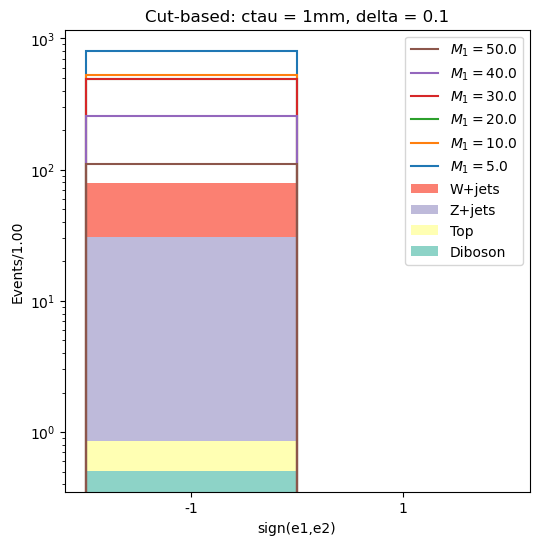

In [232]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut15', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('Cut-based: ctau = 1mm, delta = 0.1')

Text(0.5, 1.0, 'Cut-based: ctau = 10mm, delta = 0.1')

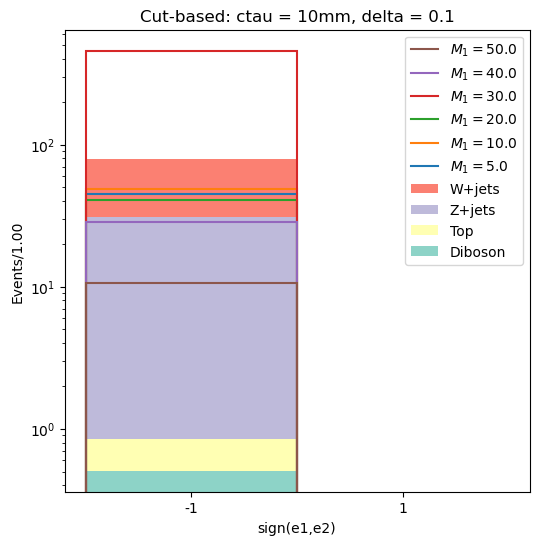

In [233]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut15', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('Cut-based: ctau = 10mm, delta = 0.1')

Text(0.5, 1.0, 'Cut-based: ctau = 100mm, delta = 0.1')

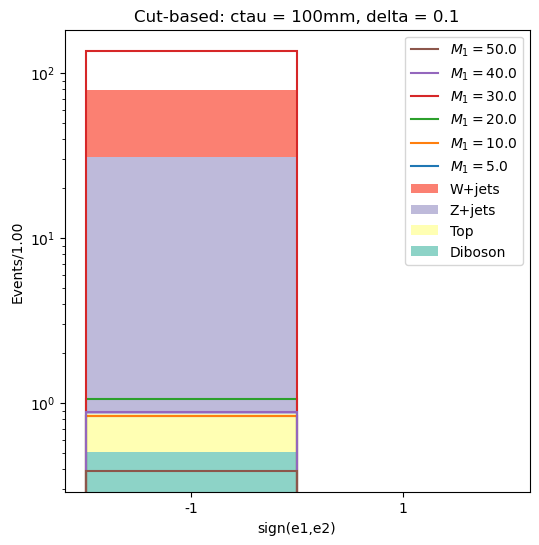

In [234]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut15', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('Cut-based: ctau = 100mm, delta = 0.1')

Text(0.5, 1.0, 'Cut-based: ctau = 1mm, delta = 0.2')

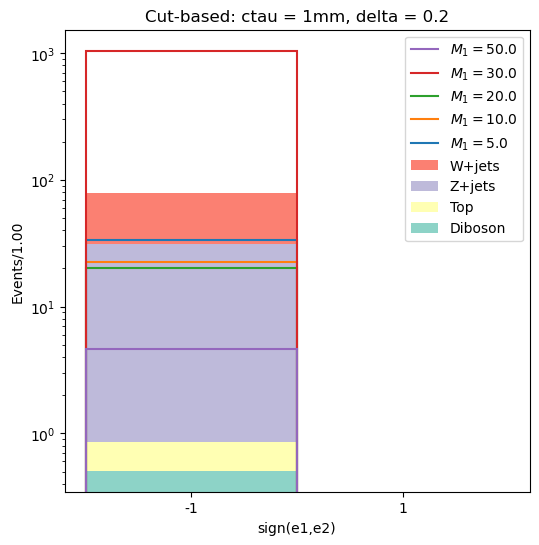

In [235]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut15', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('Cut-based: ctau = 1mm, delta = 0.2')

Text(0.5, 1.0, 'Cut-based: ctau = 10mm, delta = 0.2')

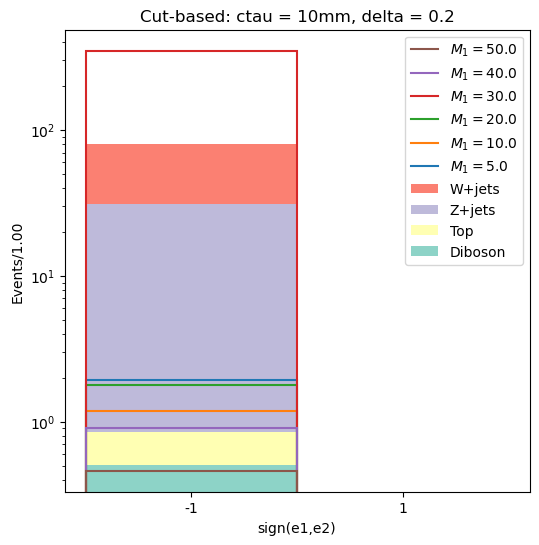

In [236]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut15', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('Cut-based: ctau = 10mm, delta = 0.2')

Text(0.5, 1.0, 'Cut-based: ctau = 100mm, delta = 0.2')

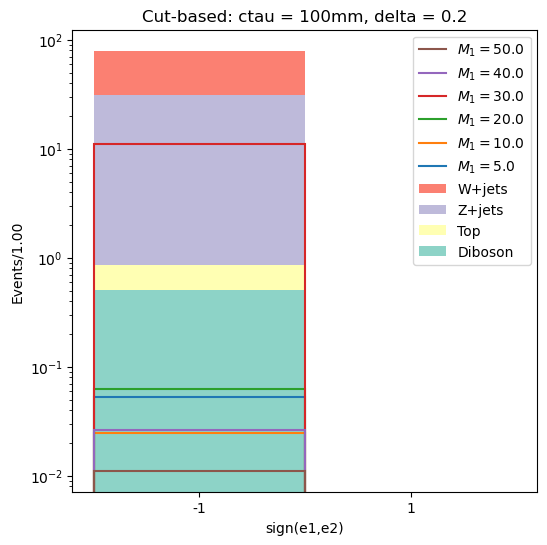

In [237]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut15', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('Cut-based: ctau = 100mm, delta = 0.2')

### 'sel_vtx_METdPhi'

Text(0.5, 1.0, 'Cut-based: ctau = 1mm, delta = 0.1')

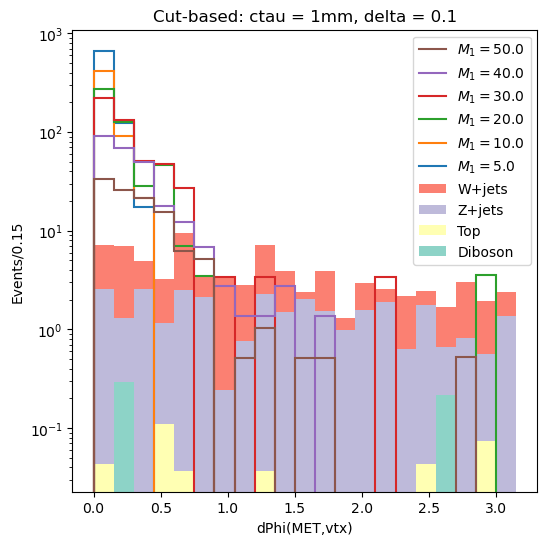

In [238]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.1
ct=1.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut15', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('Cut-based: ctau = 1mm, delta = 0.1')

Text(0.5, 1.0, 'Cut-based: ctau = 10mm, delta = 0.1')

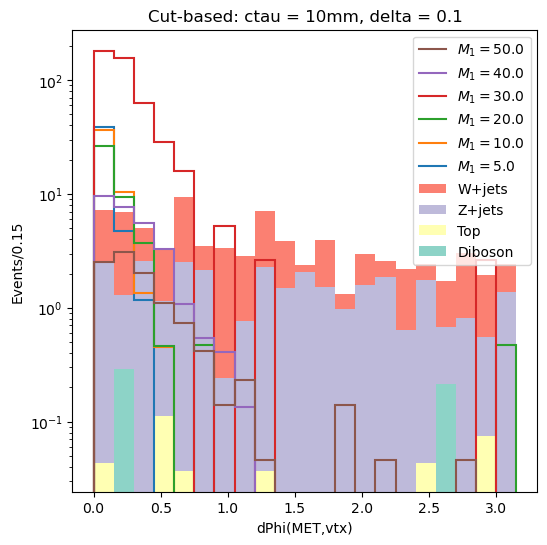

In [239]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.1
ct=10.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut15', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('Cut-based: ctau = 10mm, delta = 0.1')

Text(0.5, 1.0, 'Cut-based: ctau = 100mm, delta = 0.1')

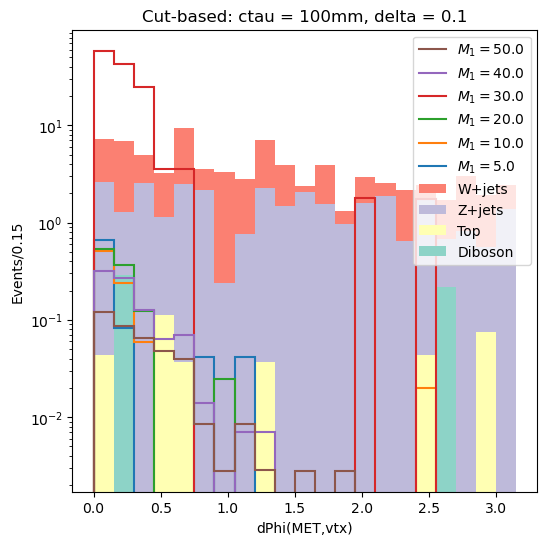

In [240]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.1
ct=100.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut15', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('Cut-based: ctau = 100mm, delta = 0.1')

Text(0.5, 1.0, 'Cut-based: ctau = 1mm, delta = 0.2')

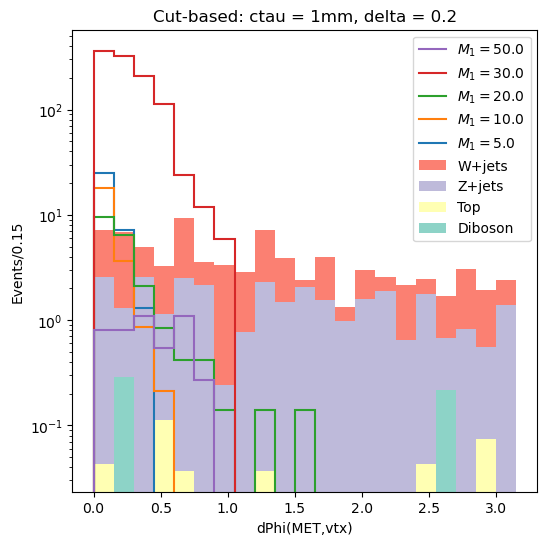

In [241]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.2
ct=1.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut15', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('Cut-based: ctau = 1mm, delta = 0.2')

Text(0.5, 1.0, 'Cut-based: ctau = 10mm, delta = 0.2')

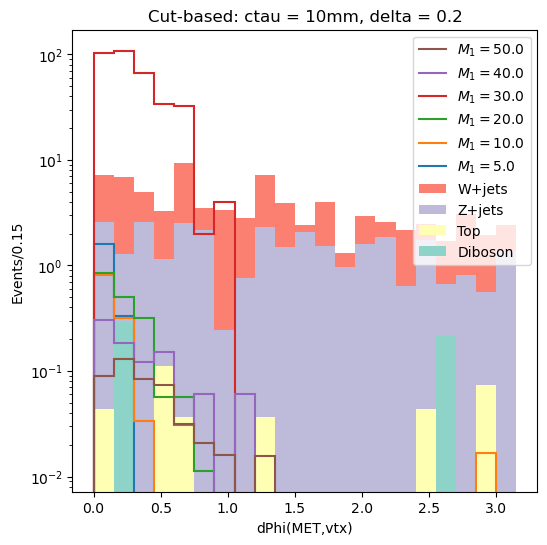

In [242]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.2
ct=10.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut15', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('Cut-based: ctau = 10mm, delta = 0.2')

Text(0.5, 1.0, 'Cut-based: ctau = 100mm, delta = 0.2')

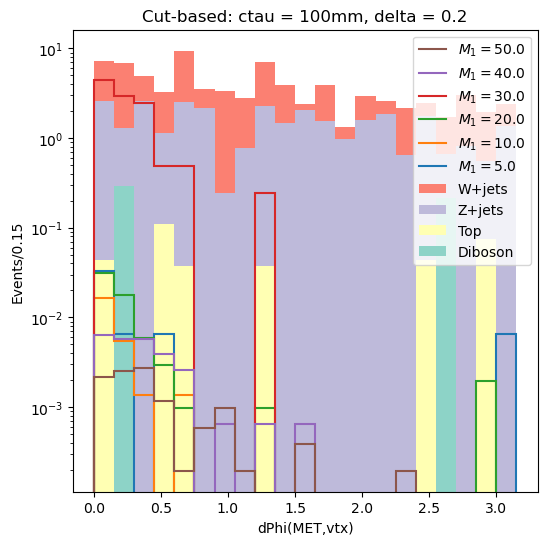

In [243]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.2
ct=100.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut15', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('Cut-based: ctau = 100mm, delta = 0.2')

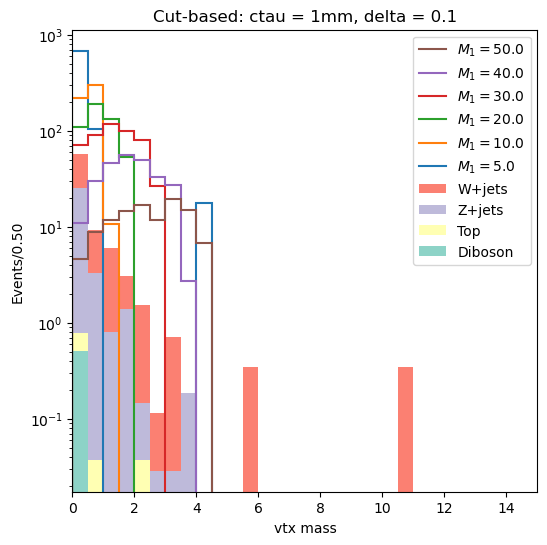

In [244]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 1j

plt.title('Cut-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut15', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

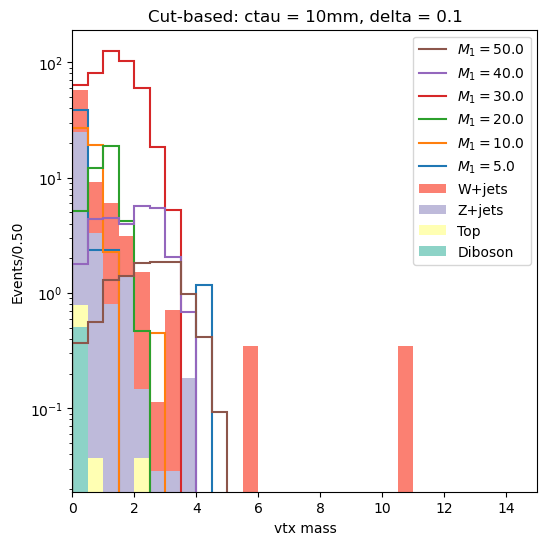

In [245]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 1j

plt.title('Cut-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut15', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

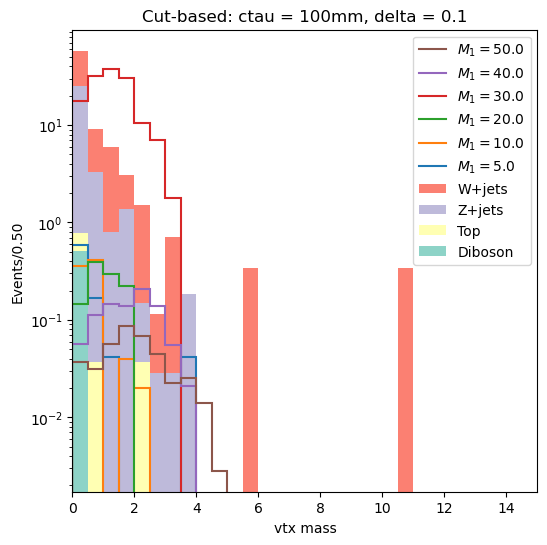

In [246]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 1j

plt.title('Cut-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut15', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

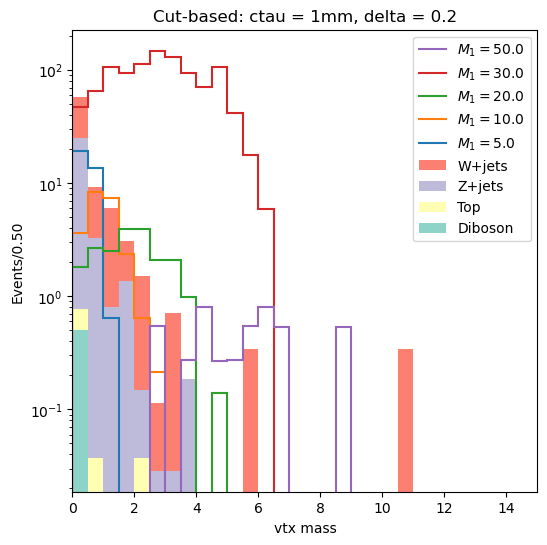

In [247]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 1j

plt.title('Cut-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut15', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

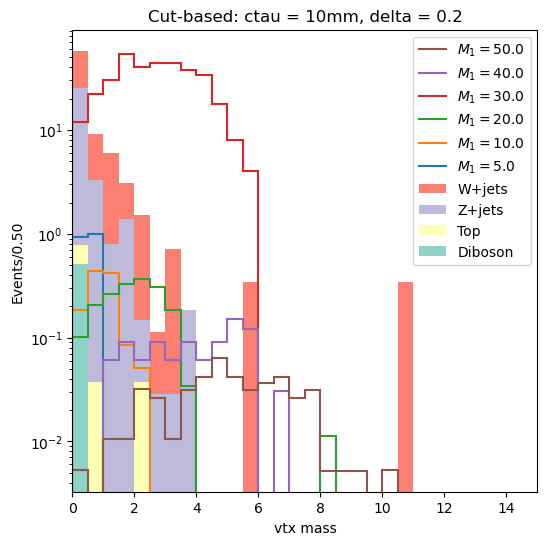

In [248]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 1j

plt.title('Cut-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut15', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

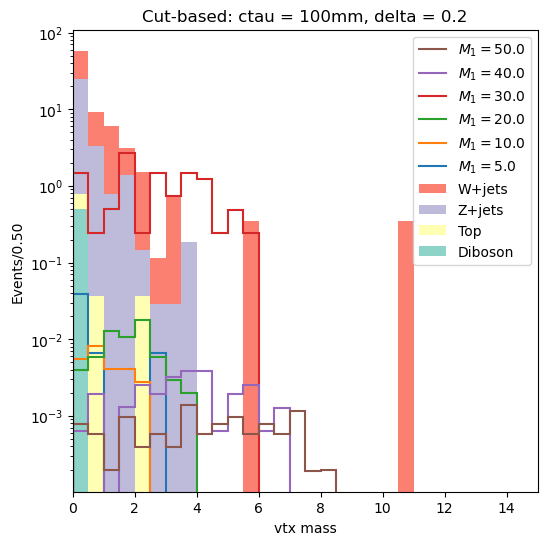

In [249]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 1j

plt.title('Cut-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut15', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

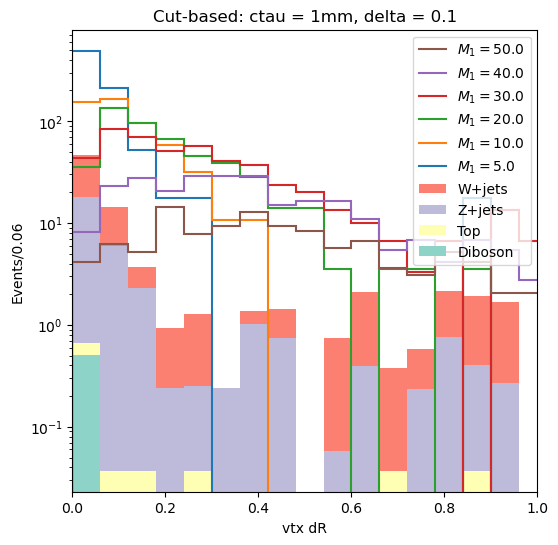

In [250]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 1j

plt.title('Cut-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut15', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx dR', doLog=True)

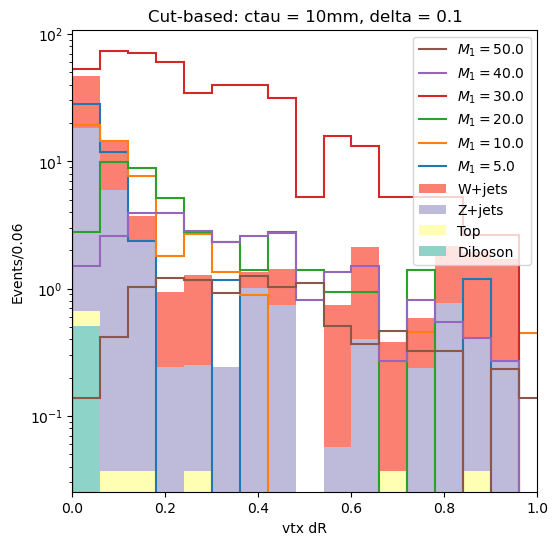

In [251]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 1j

plt.title('Cut-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut15', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx dR', doLog=True)

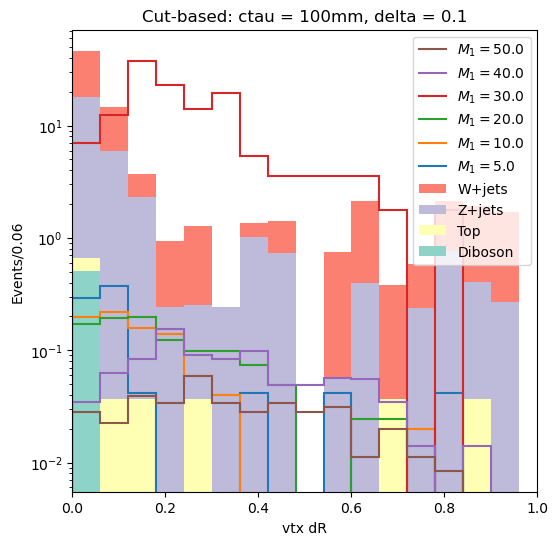

In [252]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 1j

plt.title('Cut-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut15', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx dR', doLog=True)

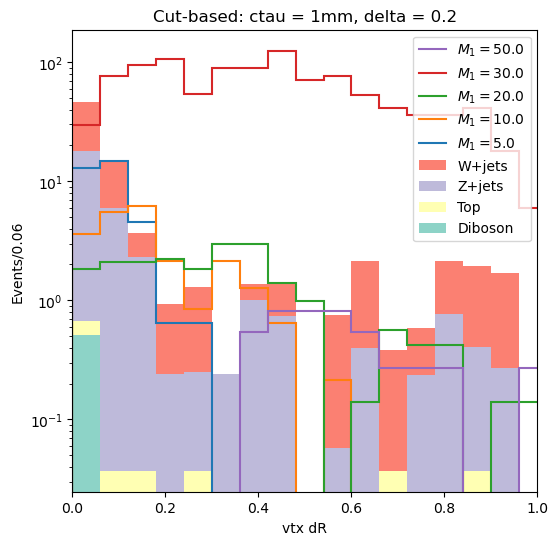

In [253]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 1j

plt.title('Cut-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut15', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx dR', doLog=True)

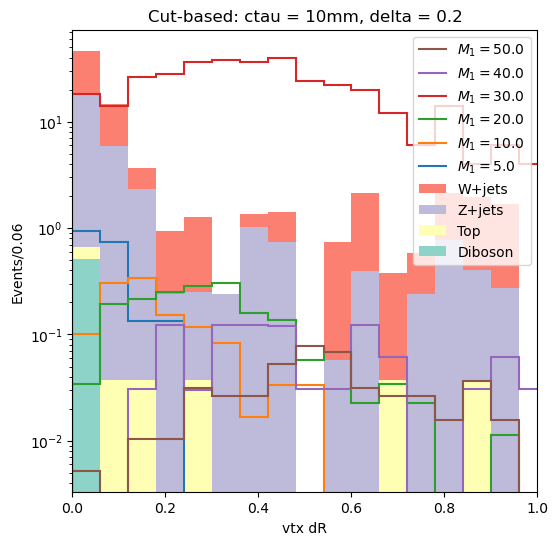

In [254]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 1j

plt.title('Cut-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut15', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx dR', doLog=True)

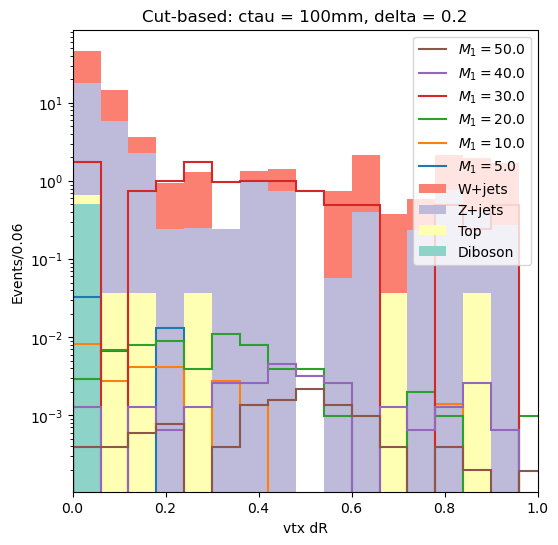

In [255]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 1j

plt.title('Cut-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut15', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx dR', doLog=True)

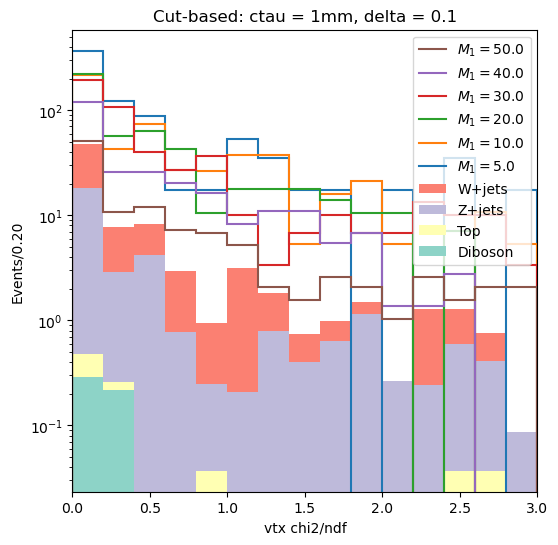

In [256]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 1j

plt.title('Cut-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut15', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

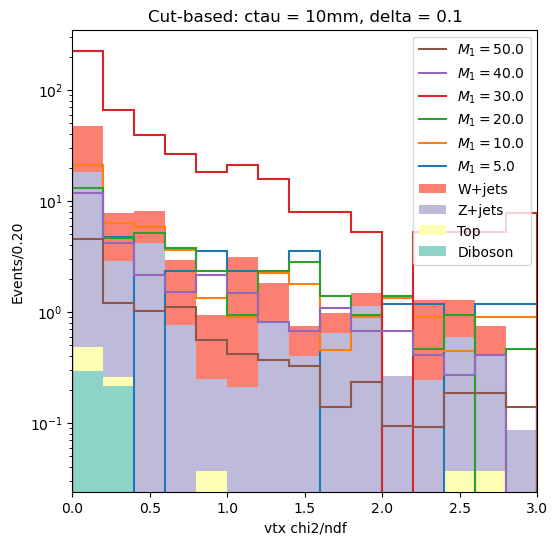

In [257]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 1j

plt.title('Cut-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut15', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

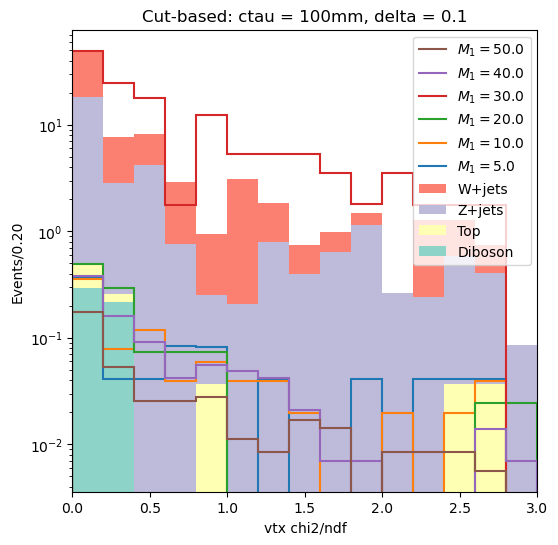

In [258]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 1j

plt.title('Cut-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut15', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

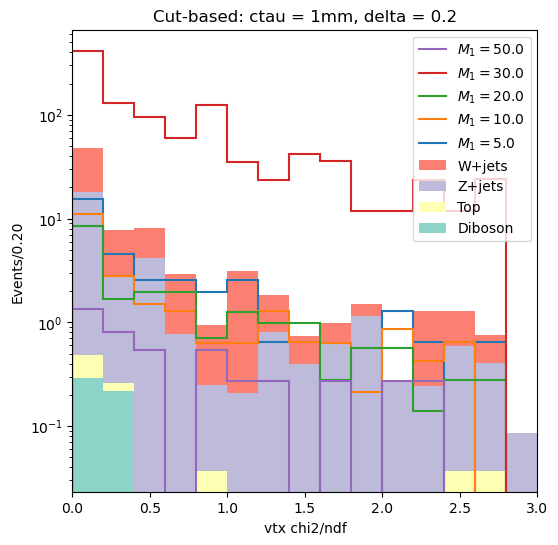

In [259]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 1j

plt.title('Cut-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut15', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

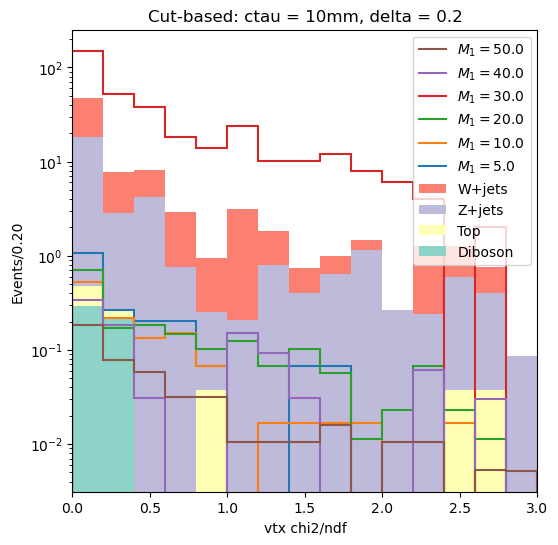

In [260]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 1j

plt.title('Cut-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut15', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

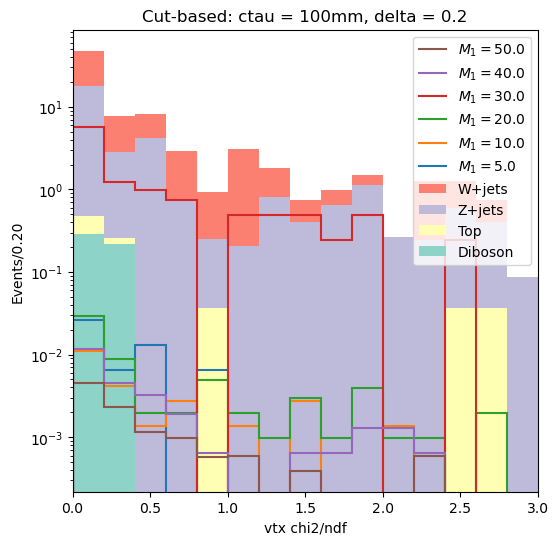

In [261]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 1j

plt.title('Cut-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut15', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

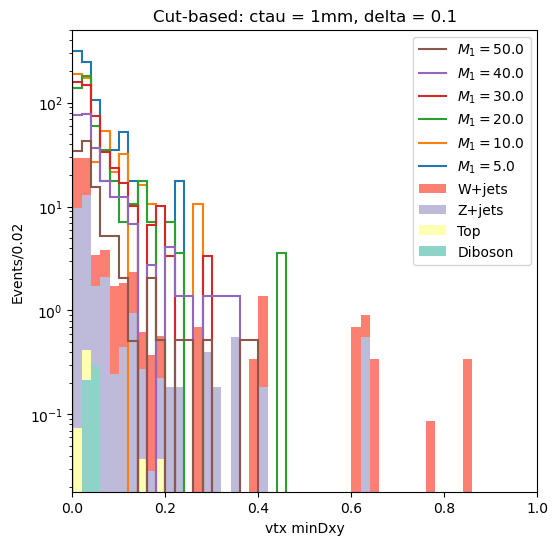

In [263]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 2j

plt.title('Cut-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

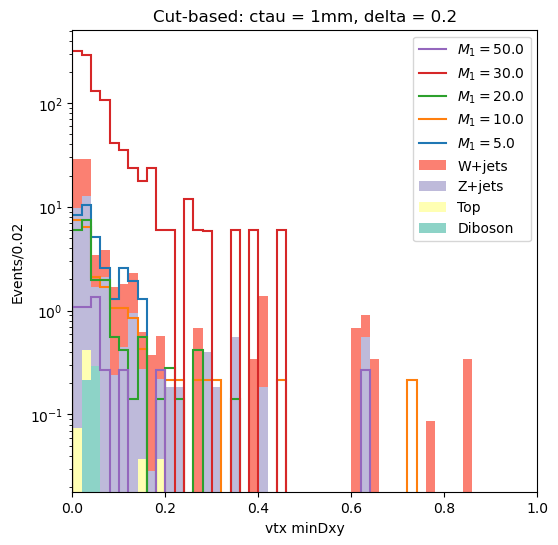

In [264]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 2j

plt.title('Cut-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

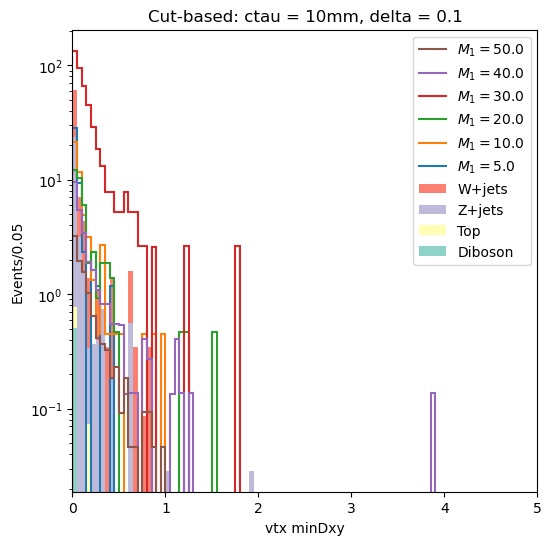

In [47]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 5j

plt.title('Cut-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,5], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

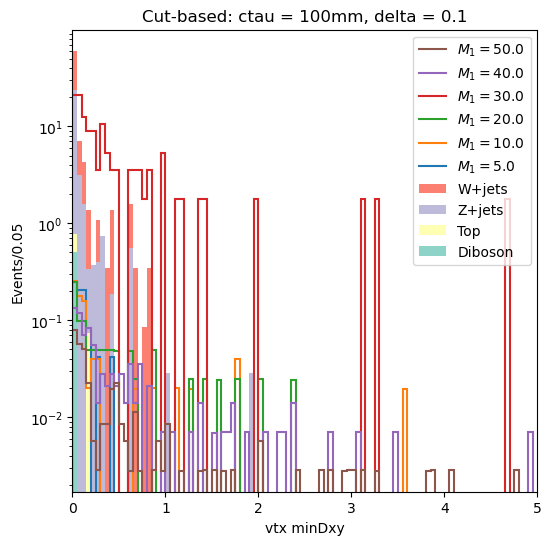

In [48]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 5j

plt.title('Cut-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,5], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

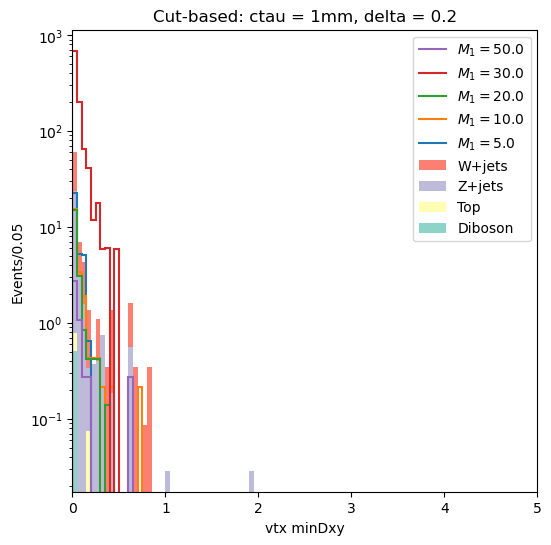

In [49]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 5j

plt.title('Cut-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,5], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

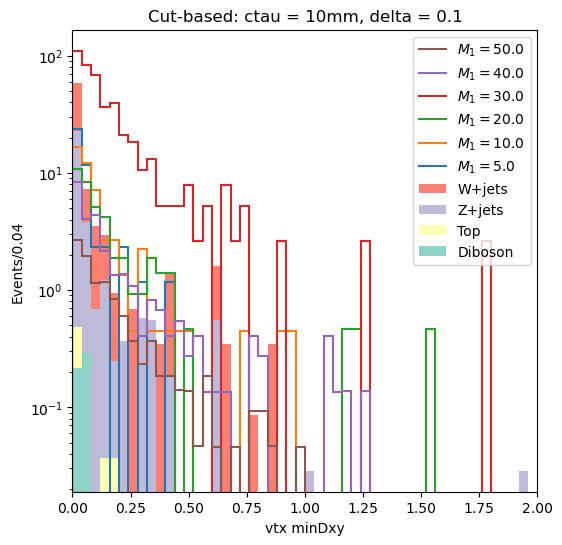

In [266]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 4j

plt.title('Cut-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,2], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

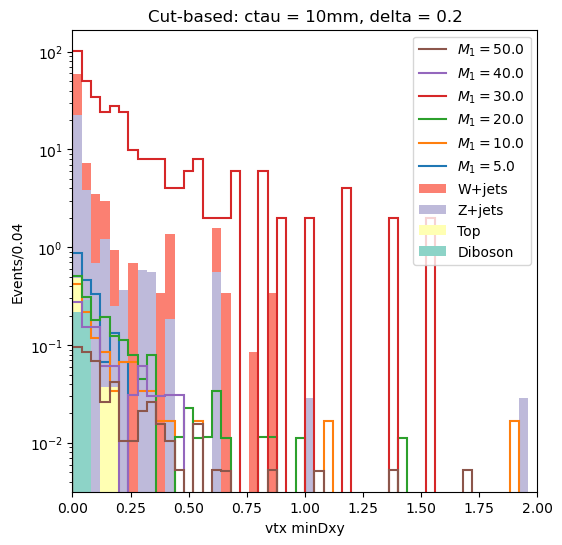

In [267]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 4j

plt.title('Cut-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,2], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

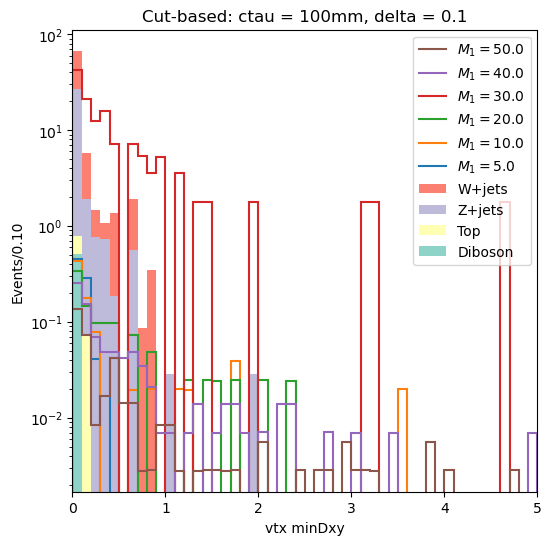

In [268]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 10j

plt.title('Cut-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,5], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

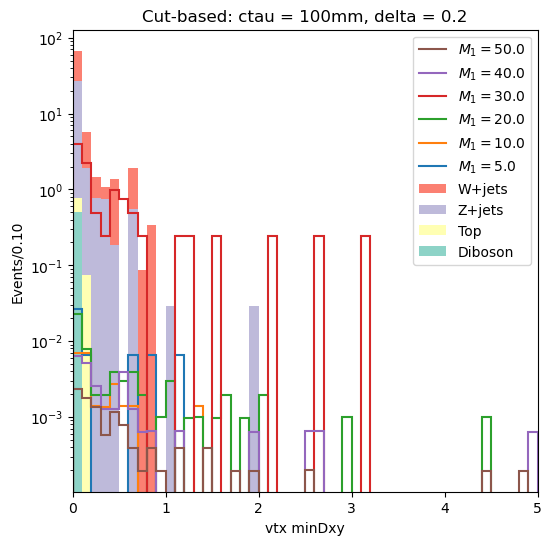

In [269]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 10j

plt.title('Cut-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,5], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

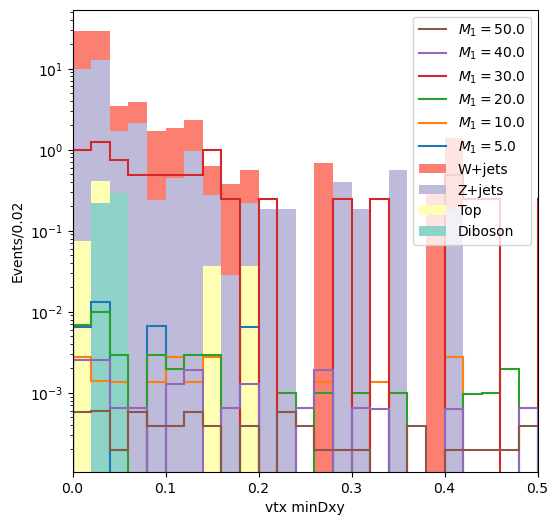

In [52]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut15', delta, ct, xlim=[0,0.5], rebin=2j, xlabel = 'vtx minDxy', doLog=True)

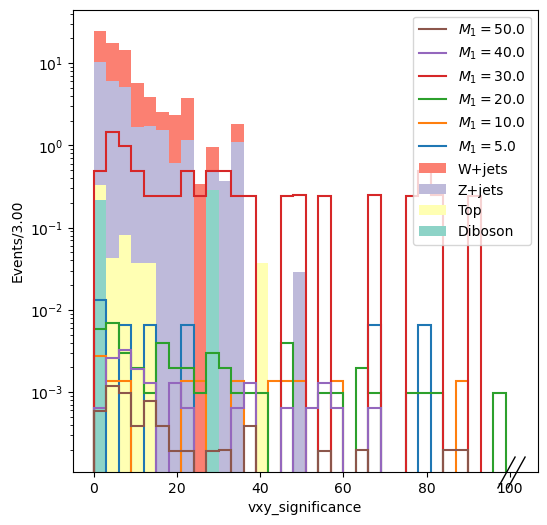

In [53]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut15', delta, ct, rebin=3j, xlabel = 'vxy_significance', doLog=True)

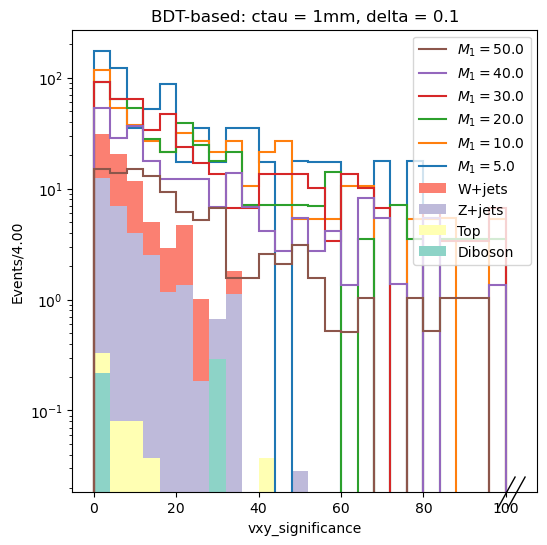

In [271]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 4j

plt.title('BDT-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut15', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

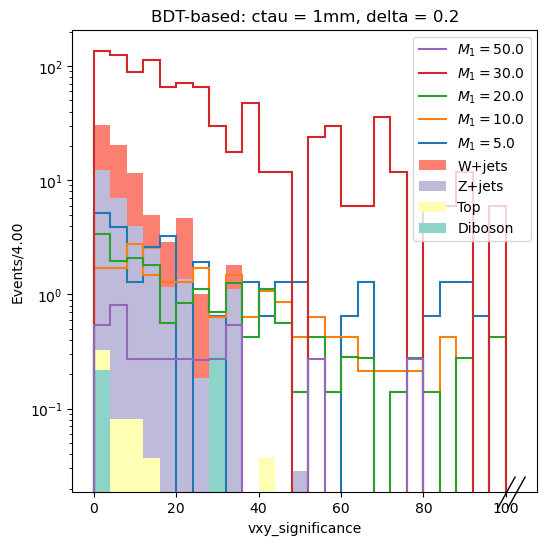

In [274]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 4j

plt.title('BDT-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut15', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

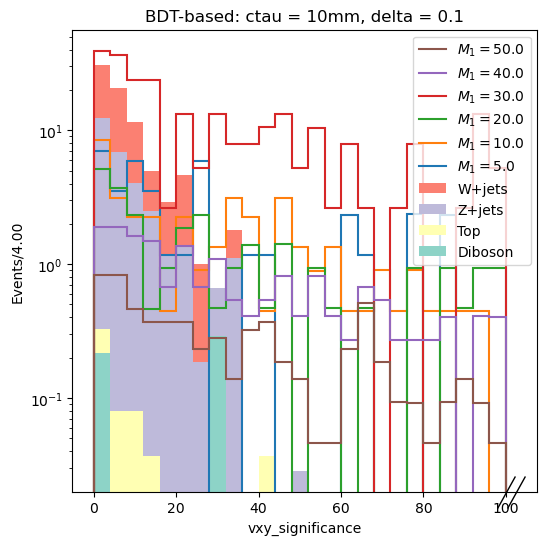

In [272]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 4j

plt.title('BDT-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut15', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

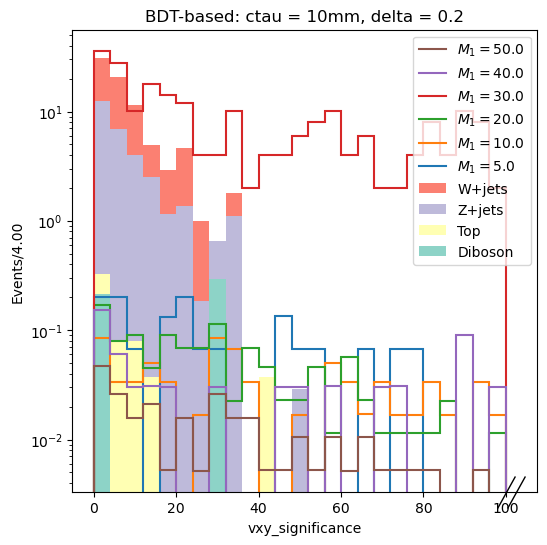

In [275]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 4j

plt.title('BDT-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut15', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

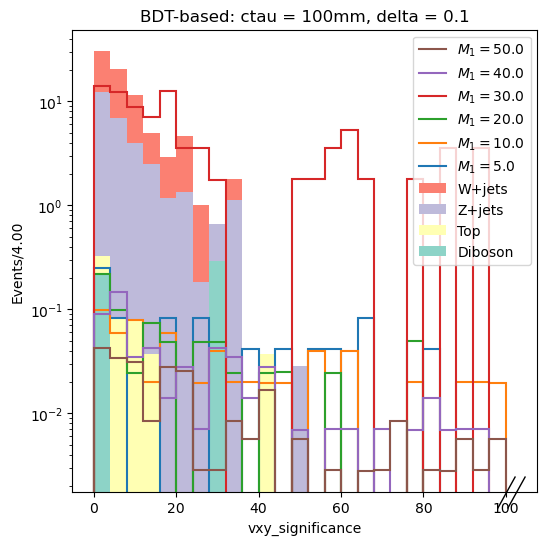

In [273]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 4j

plt.title('BDT-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut15', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

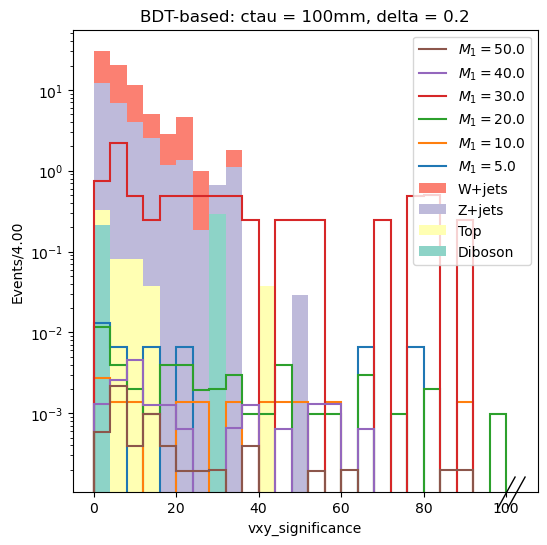

In [276]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 4j

plt.title('BDT-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut15', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

### BDTv2 ctau-1

In [54]:
prefix = '../SR_BDT-based/BDTv2_per_ctau/coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-1_5to50_skimmed'

# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD after OSSF cut
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

In [55]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
print(sig_samples)

['sig_2018_Mchi-55p0_dMchi-10p0_ctau-1', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-1', 'sig_2018_Mchi-5p5_dMchi-1p0_ctau-1', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-1', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-1', 'sig_2018_Mchi-11p0_dMchi-2p0_ctau-1', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-1']


In [56]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
print(cuts)

['all', 'hasVtx', 'cut5', 'cut6', 'cut7', 'cut8', 'cut9', 'cut10']


In [57]:
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

print(si)

                                       mchi  dmchi  ctau    m1    m2  delta  \
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1  55.00   10.0   1.0  50.0  60.0    0.2   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1    5.25    0.5   1.0   5.0   5.5    0.1   
sig_2018_Mchi-5p5_dMchi-1p0_ctau-1     5.50    1.0   1.0   5.0   6.0    0.2   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1   52.50    5.0   1.0  50.0  55.0    0.1   
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1   33.00    6.0   1.0  30.0  36.0    0.2   
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1   42.00    4.0   1.0  40.0  44.0    0.1   
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1   31.50    3.0   1.0  30.0  33.0    0.1   
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1   22.00    4.0   1.0  20.0  24.0    0.2   
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1   21.00    2.0   1.0  20.0  22.0    0.1   
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1   11.00    2.0   1.0  10.0  12.0    0.2   
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1   10.50    1.0   1.0  10.0  11.0    0.1   

                                                   

In [58]:
deltas = sorted(list(set(si.delta)))
m1s = sorted(list(set(si.m1)))
all_ctaus = sorted(list(set(si.ctau)))

In [59]:
bkg = {}

for h in histograms:
    bkg[h] = {}
    for b in bkg_histos.keys():
        if type(bkg_histos[b][h]) == hist.Hist and bkg_histos[b][h].sum(flow=True).value > 0:
            bkg[h][b] = bkg_histos[b][h][{"samp":sum}]

def plot_bkg(hname, cut, rebin=1j, doLog=True, xlim = [], title='', doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    plt.title(title)
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

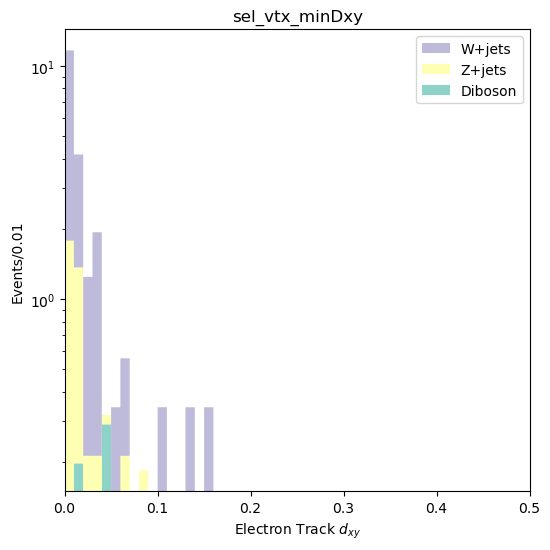

In [60]:
plot_bkg('sel_vtx_minDxy', 'cut10', xlim = [0, 0.5], title='sel_vtx_minDxy', rebin=1j)

In [61]:
def plot_sig(hname, cut, delta, m1, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
    hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
    mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

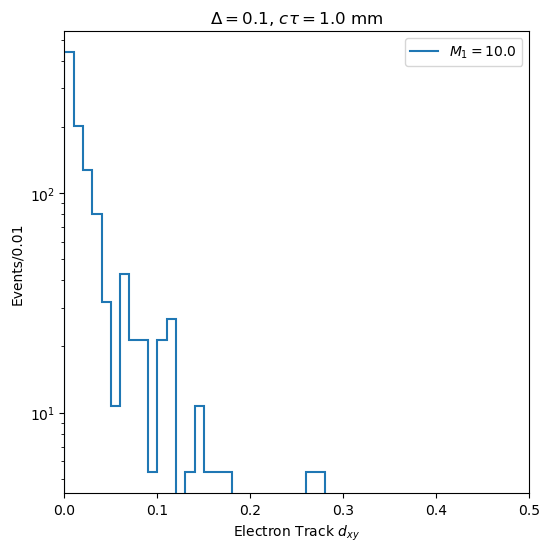

In [62]:
delta = deltas[0]
m1 = m1s[1]
ct = all_ctaus[0]

plot_sig('sel_vtx_minDxy', cut='cut10', xlim = [0, 0.5], delta=delta, m1=m1, ct=ct)

In [63]:
def plot_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

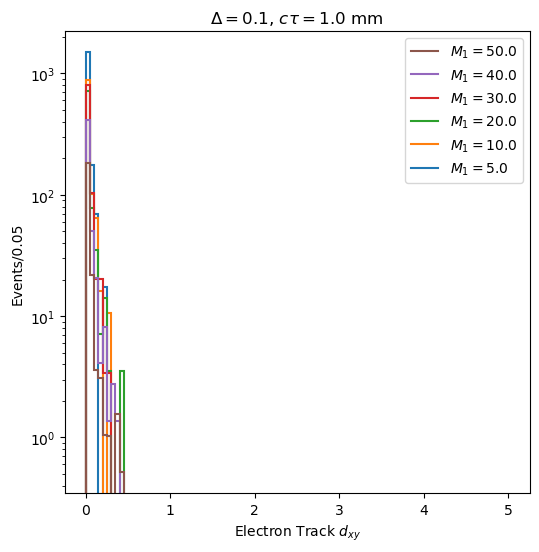

In [64]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, rebin=5j)

In [65]:
def plot_bkg_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], xlabel='', flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):    
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    # bkg
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    # signal
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    #plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel('Events/{:.2f}'.format(binwidth))

    if xlabel != '':
        plt.xlabel(xlabel)
    
    if doLog:
        plt.yscale('log')
    plt.legend()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')

    if xlim != []:
        plt.xlim(xlim)
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

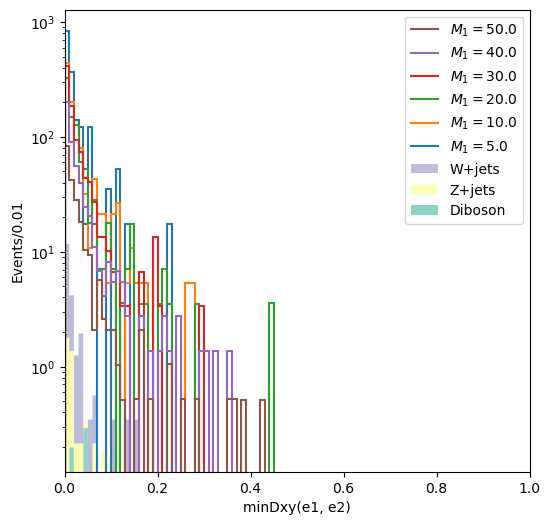

In [66]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, rebin=1j, xlim=[0,1], xlabel = 'minDxy(e1, e2)', doLog=True)

'sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif'

### 'sel_vtx_sign'

Text(0.5, 1.0, 'BDT-based: ctau = 1mm, delta = 0.1')

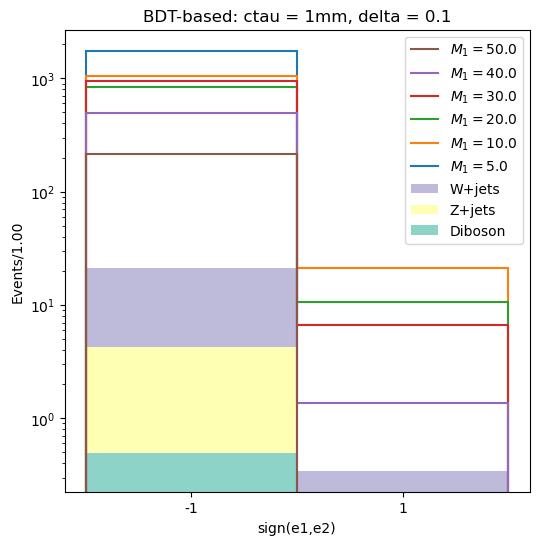

In [67]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut10', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('BDT-based: ctau = 1mm, delta = 0.1')

Text(0.5, 1.0, 'BDT-based: ctau = 1mm, delta = 0.2')

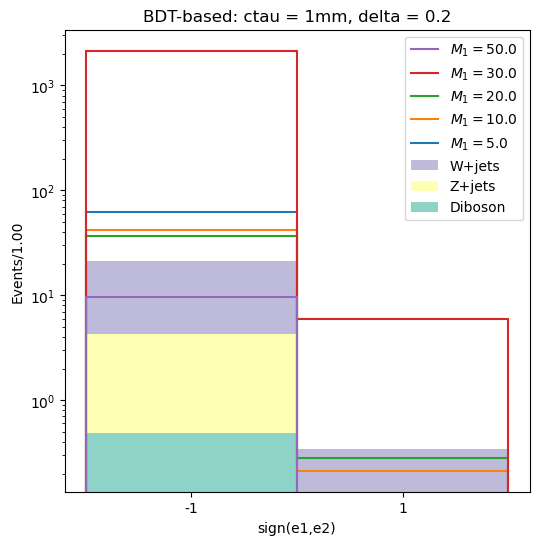

In [68]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut10', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('BDT-based: ctau = 1mm, delta = 0.2')

### 'sel_vtx_METdPhi'

Text(0.5, 1.0, 'BDT-based: ctau = 1mm, delta = 0.1')

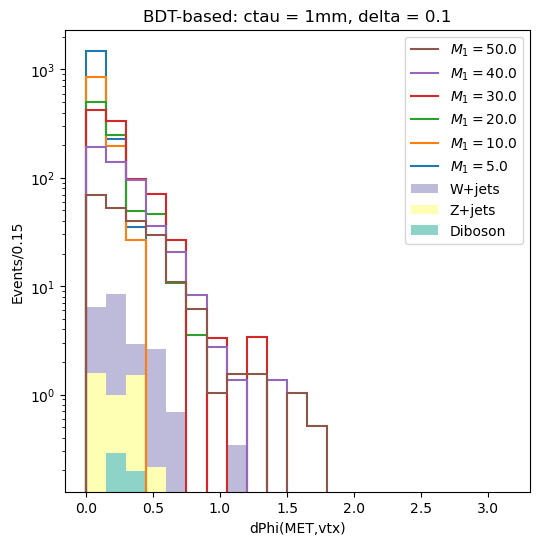

In [69]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.1
ct=1.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut10', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('BDT-based: ctau = 1mm, delta = 0.1')

Text(0.5, 1.0, 'BDT-based: ctau = 1mm, delta = 0.2')

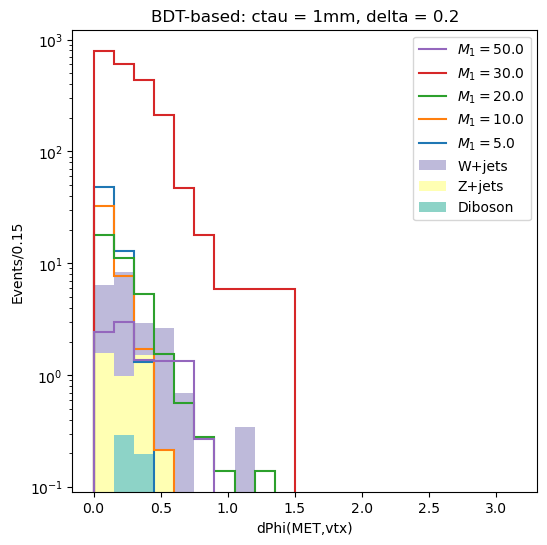

In [70]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.2
ct=1.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut10', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('BDT-based: ctau = 1mm, delta = 0.2')

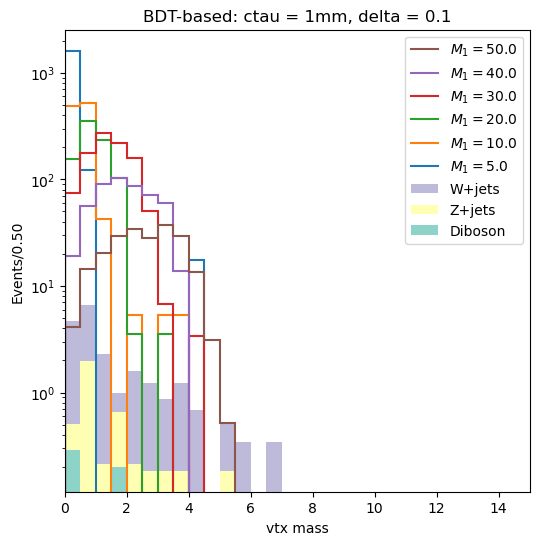

In [71]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 1j

plt.title('BDT-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut10', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

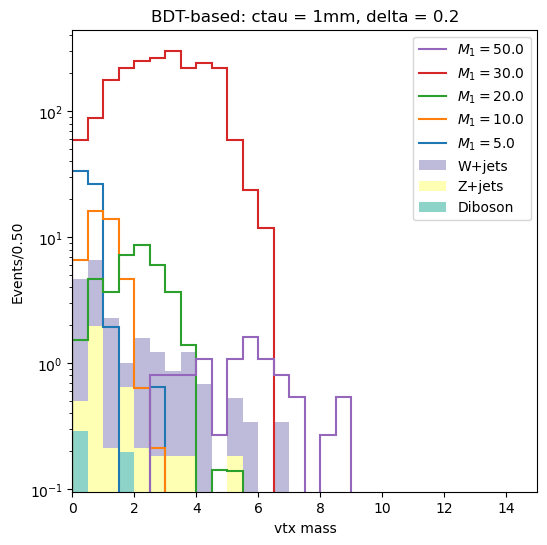

In [72]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 1j

plt.title('BDT-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut10', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

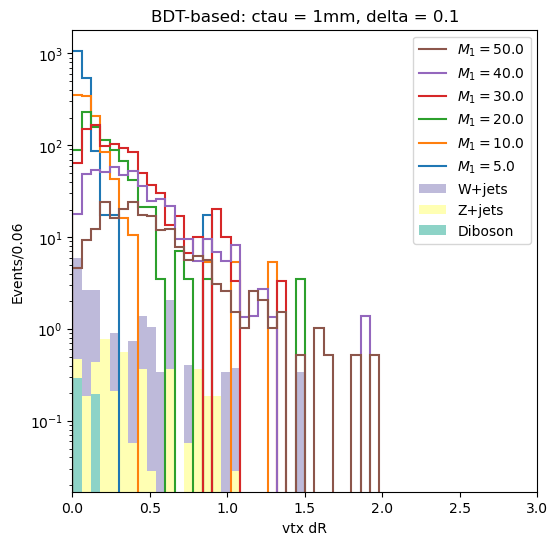

In [73]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 1j

plt.title('BDT-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx dR', doLog=True)

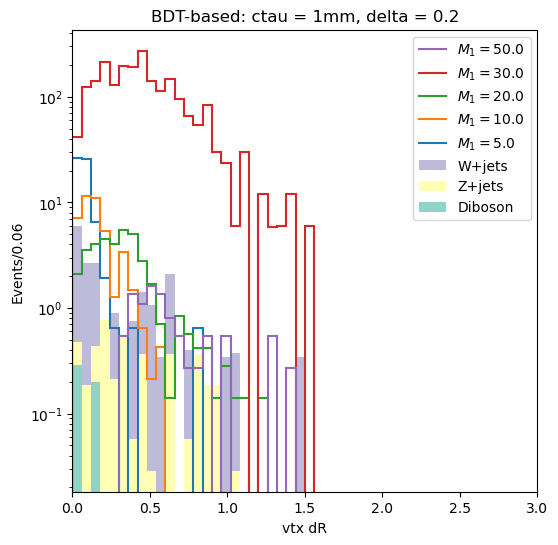

In [74]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 1j

plt.title('BDT-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx dR', doLog=True)

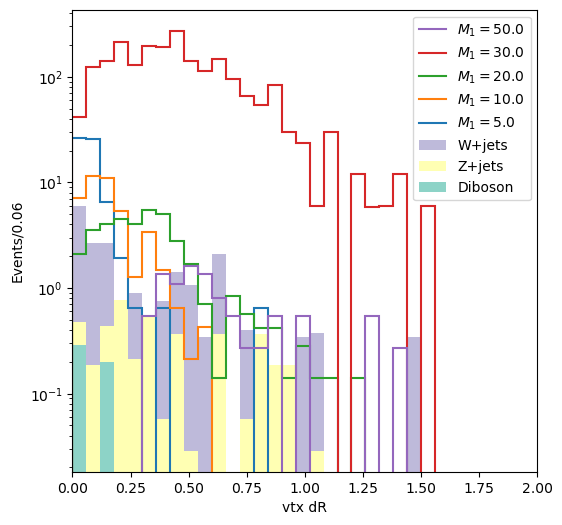

In [75]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,2], rebin=1j, xlabel = 'vtx dR', doLog=True)

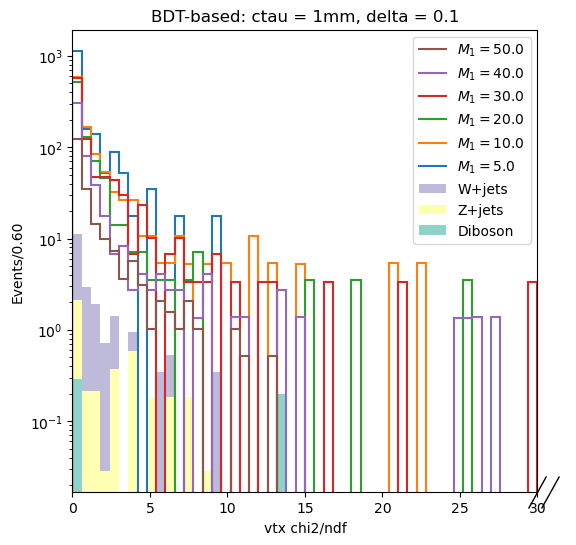

In [76]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 3j

plt.title('BDT-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut10', delta, ct, xlim=[0,30], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

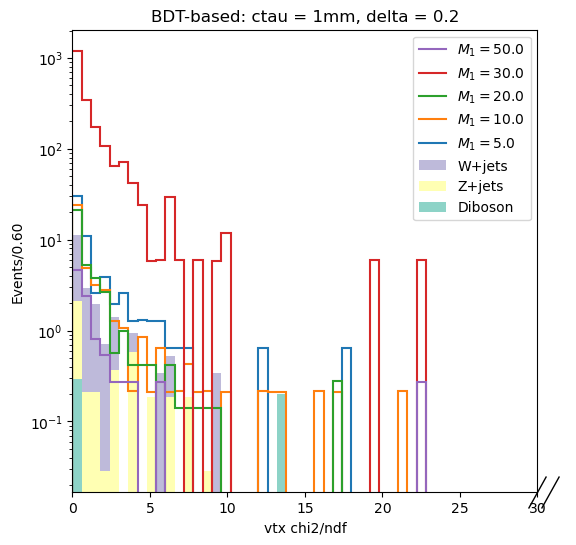

In [77]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 3j

plt.title('BDT-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut10', delta, ct, xlim=[0,30], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

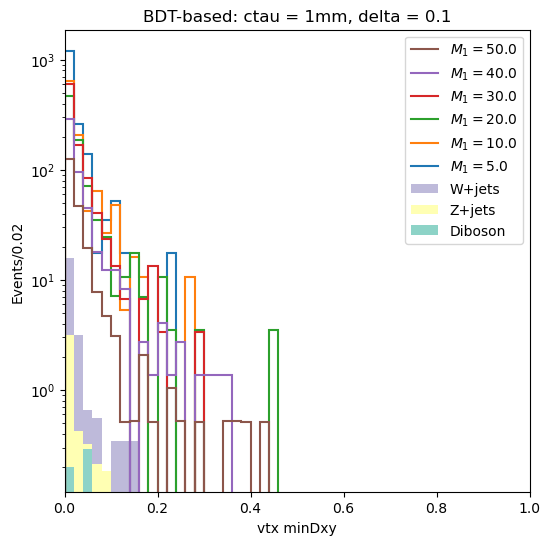

In [78]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 2j

plt.title('BDT-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

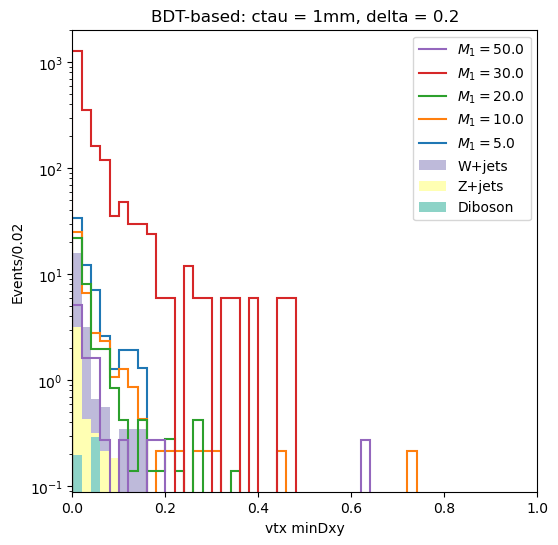

In [79]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 2j

plt.title('BDT-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, xlim=[0,1], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

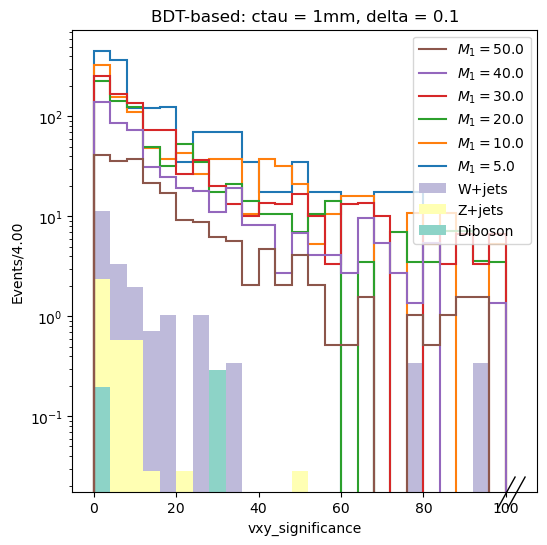

In [82]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=1.0

rebin = 4j

plt.title('BDT-based: ctau = 1mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut10', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

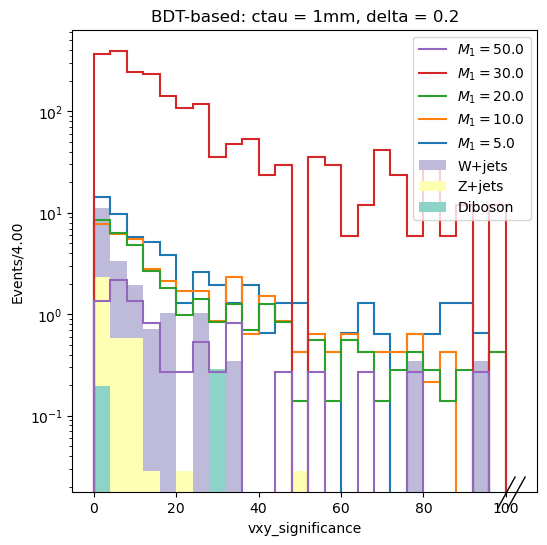

In [83]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=1.0

rebin = 4j

plt.title('BDT-based: ctau = 1mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut10', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

### BDTv2 ctau-10

In [84]:
prefix = '../SR_BDT-based/BDTv2_per_ctau/coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-10_5to50_skimmed'

# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD after OSSF cut
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

In [85]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
print(sig_samples)

['sig_2018_Mchi-5p5_dMchi-1p0_ctau-10', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-10', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-10', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10', 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-10', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-10', 'sig_2018_Mchi-11p0_dMchi-2p0_ctau-10', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-10']


In [86]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
print(cuts)

['all', 'hasVtx', 'cut5', 'cut6', 'cut7', 'cut8', 'cut9', 'cut10']


In [87]:
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

print(si)

                                        mchi  dmchi  ctau    m1    m2  delta  \
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10     5.50    1.0  10.0   5.0   6.0    0.2   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10  55.00   10.0  10.0  50.0  60.0    0.2   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10    5.25    0.5  10.0   5.0   5.5    0.1   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10   52.50    5.0  10.0  50.0  55.0    0.1   
sig_2018_Mchi-44p0_dMchi-8p0_ctau-10   44.00    8.0  10.0  40.0  48.0    0.2   
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10   42.00    4.0  10.0  40.0  44.0    0.1   
sig_2018_Mchi-33p0_dMchi-6p0_ctau-10   33.00    6.0  10.0  30.0  36.0    0.2   
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10   31.50    3.0  10.0  30.0  33.0    0.1   
sig_2018_Mchi-22p0_dMchi-4p0_ctau-10   22.00    4.0  10.0  20.0  24.0    0.2   
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10   21.00    2.0  10.0  20.0  22.0    0.1   
sig_2018_Mchi-11p0_dMchi-2p0_ctau-10   11.00    2.0  10.0  10.0  12.0    0.2   
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10   1

In [88]:
deltas = sorted(list(set(si.delta)))
m1s = sorted(list(set(si.m1)))
all_ctaus = sorted(list(set(si.ctau)))

In [89]:
bkg = {}

for h in histograms:
    bkg[h] = {}
    for b in bkg_histos.keys():
        if type(bkg_histos[b][h]) == hist.Hist and bkg_histos[b][h].sum(flow=True).value > 0:
            bkg[h][b] = bkg_histos[b][h][{"samp":sum}]

def plot_bkg(hname, cut, rebin=1j, doLog=True, xlim = [], title='', doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    plt.title(title)
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

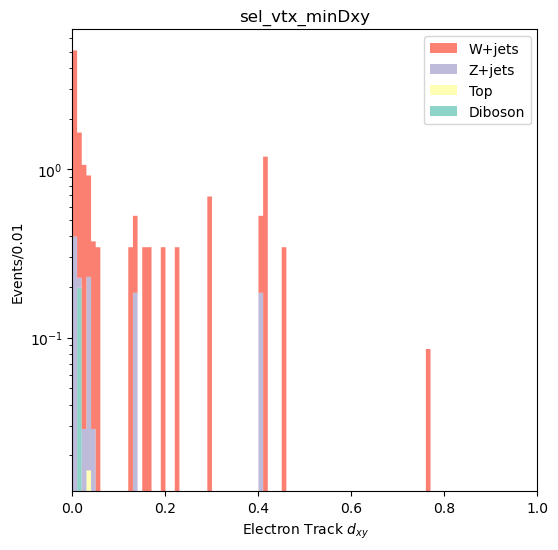

In [90]:
plot_bkg('sel_vtx_minDxy', 'cut10', xlim = [0, 1], title='sel_vtx_minDxy', rebin=1j)

In [91]:
def plot_sig(hname, cut, delta, m1, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
    hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
    mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

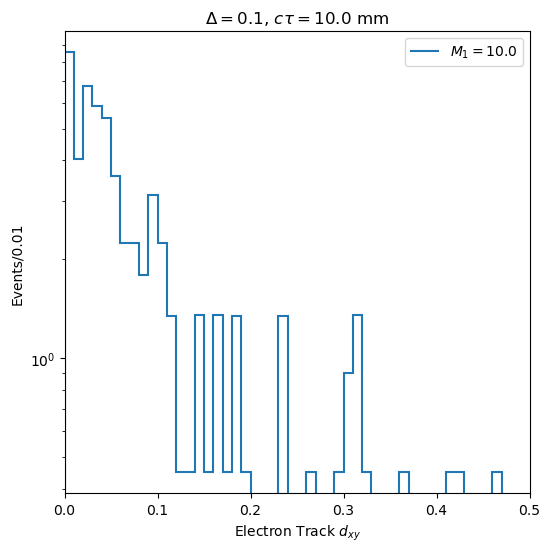

In [92]:
delta = deltas[0]
m1 = m1s[1]
ct = all_ctaus[0]

plot_sig('sel_vtx_minDxy', cut='cut10', xlim = [0, 0.5], delta=delta, m1=m1, ct=ct)

In [93]:
def plot_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

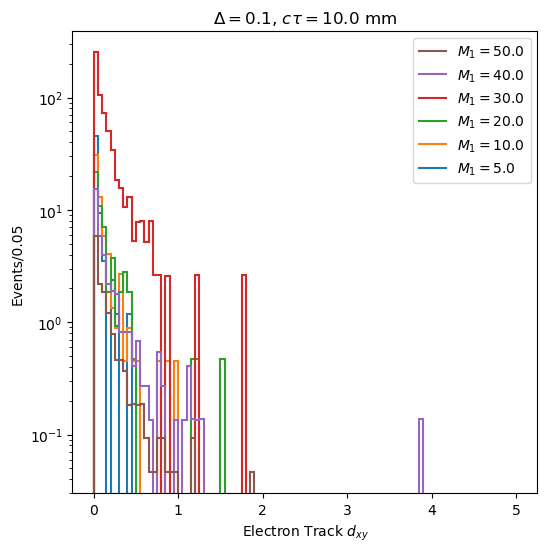

In [94]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, rebin=5j)

In [95]:
def plot_bkg_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], xlabel='', flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):    
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    # bkg
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    # signal
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    #plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel('Events/{:.2f}'.format(binwidth))

    if xlabel != '':
        plt.xlabel(xlabel)
    
    if doLog:
        plt.yscale('log')
    plt.legend()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')

    if xlim != []:
        plt.xlim(xlim)
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

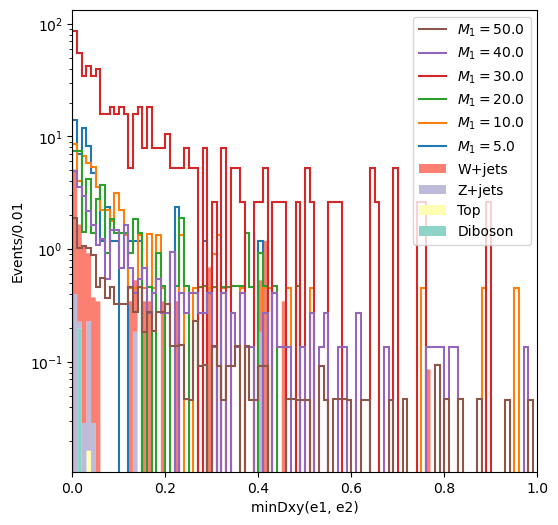

In [96]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, rebin=1j, xlim=[0,1], xlabel = 'minDxy(e1, e2)', doLog=True)

### 'sel_vtx_sign'

Text(0.5, 1.0, 'BDT-based: ctau = 10mm, delta = 0.1')

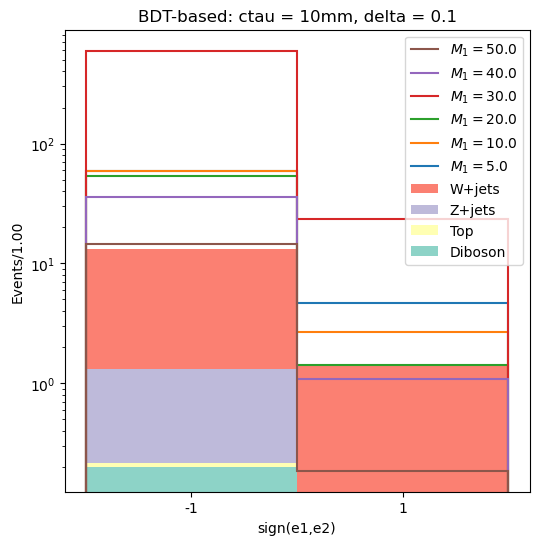

In [98]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut10', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('BDT-based: ctau = 10mm, delta = 0.1')

Text(0.5, 1.0, 'BDT-based: ctau = 10mm, delta = 0.2')

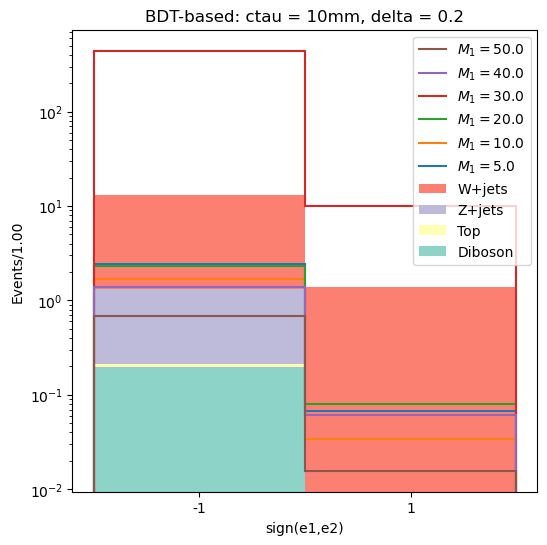

In [99]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut10', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('BDT-based: ctau = 10mm, delta = 0.2')

### 'sel_vtx_METdPhi'

Text(0.5, 1.0, 'BDT-based: ctau = 10mm, delta = 0.1')

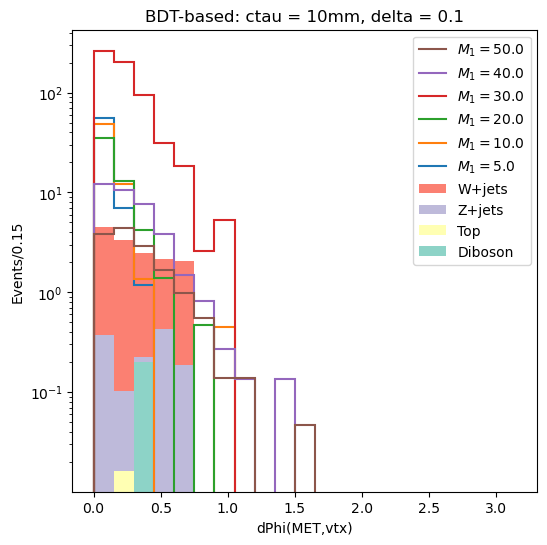

In [100]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.1
ct=10.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut10', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('BDT-based: ctau = 10mm, delta = 0.1')

Text(0.5, 1.0, 'BDT-based: ctau = 10mm, delta = 0.2')

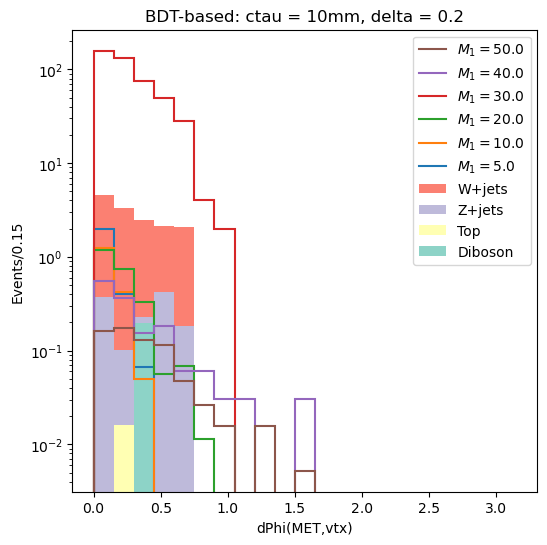

In [101]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.2
ct=10.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut10', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('BDT-based: ctau = 10mm, delta = 0.2')

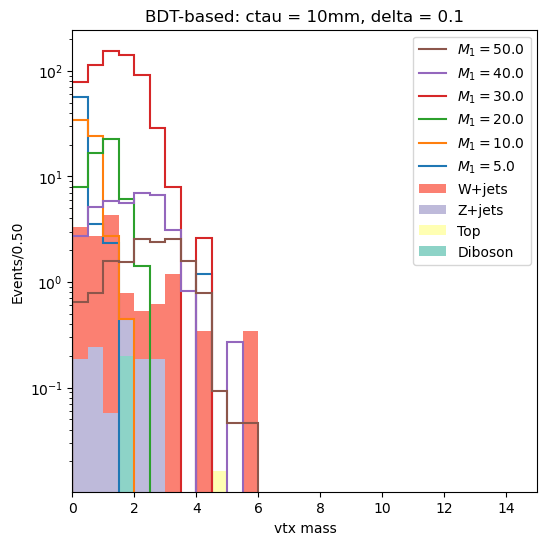

In [102]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 1j

plt.title('BDT-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut10', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

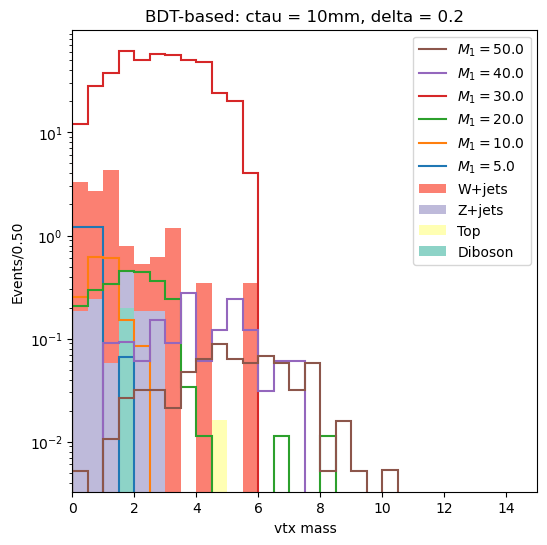

In [103]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 1j

plt.title('BDT-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut10', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

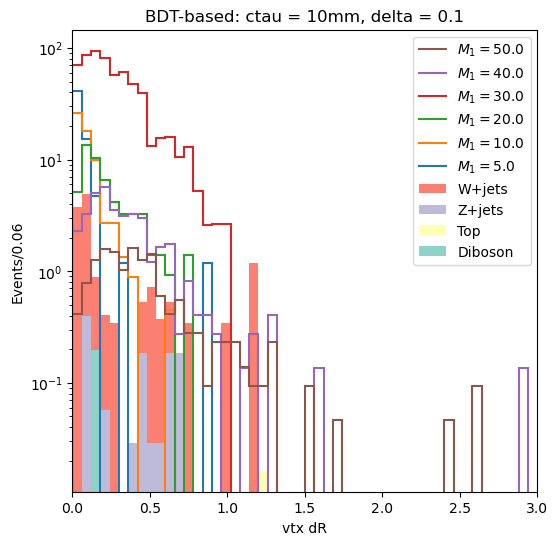

In [106]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 1j

plt.title('BDT-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx dR', doLog=True)

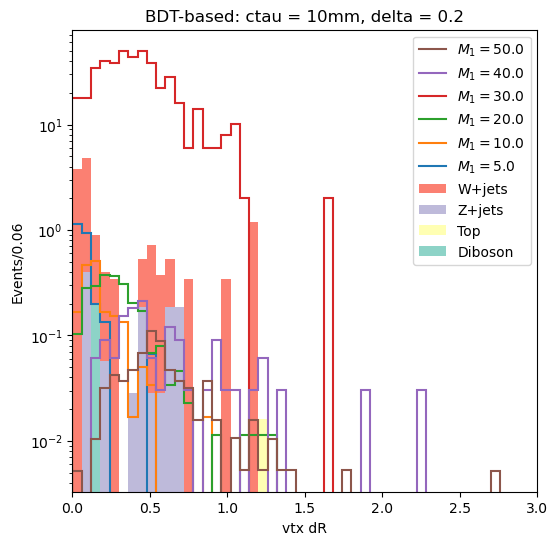

In [109]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 1j

plt.title('BDT-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx dR', doLog=True)

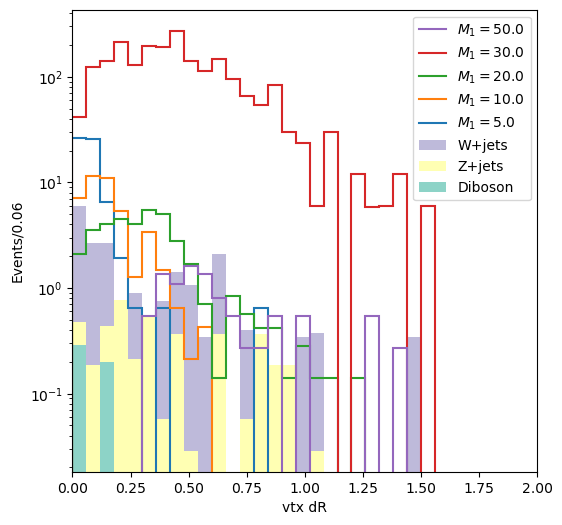

In [75]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,2], rebin=1j, xlabel = 'vtx dR', doLog=True)

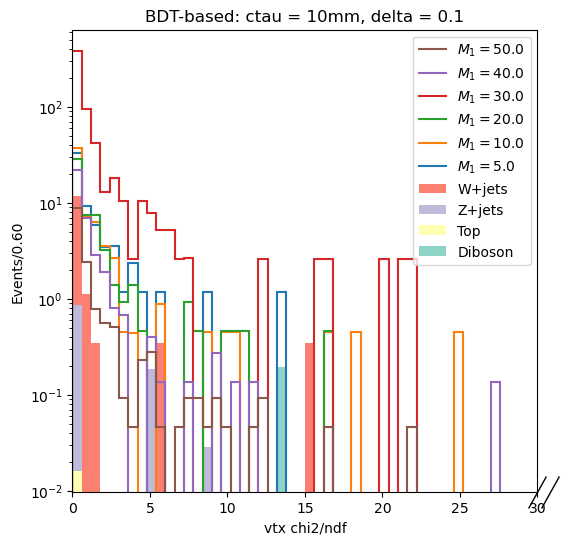

In [113]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 3j

plt.title('BDT-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut10', delta, ct, xlim=[0,30], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

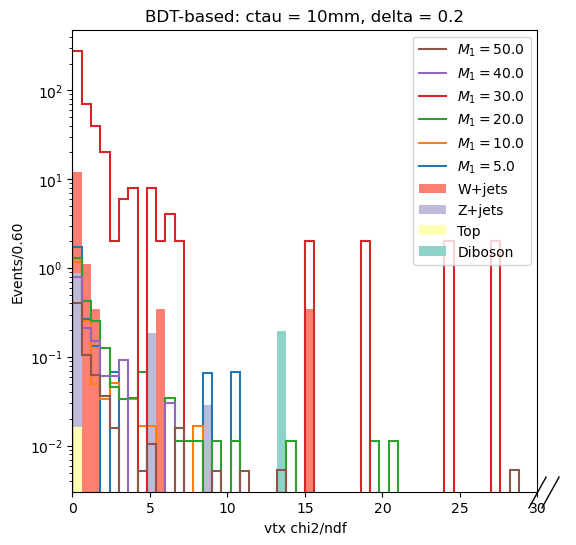

In [114]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 3j

plt.title('BDT-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut10', delta, ct, xlim=[0,30], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

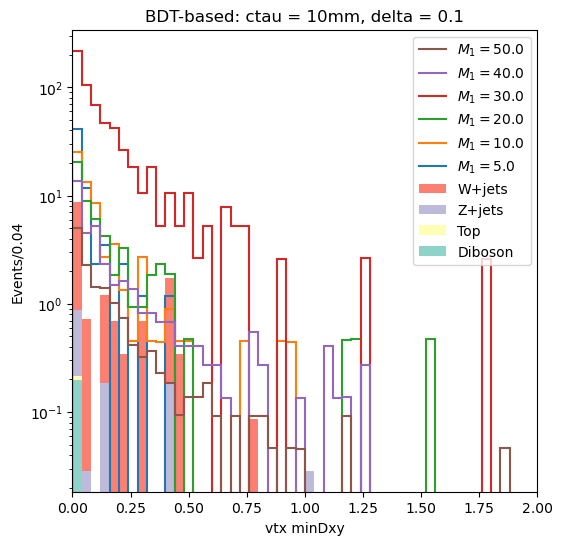

In [120]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 4j

plt.title('BDT-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, xlim=[0,2], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

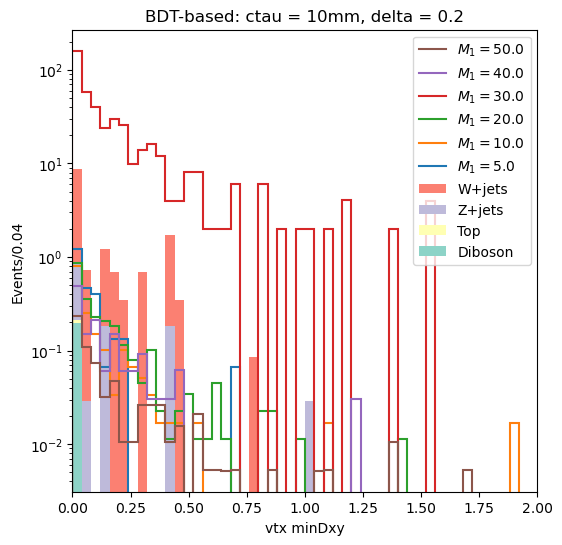

In [119]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 4j

plt.title('BDT-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, xlim=[0,2], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

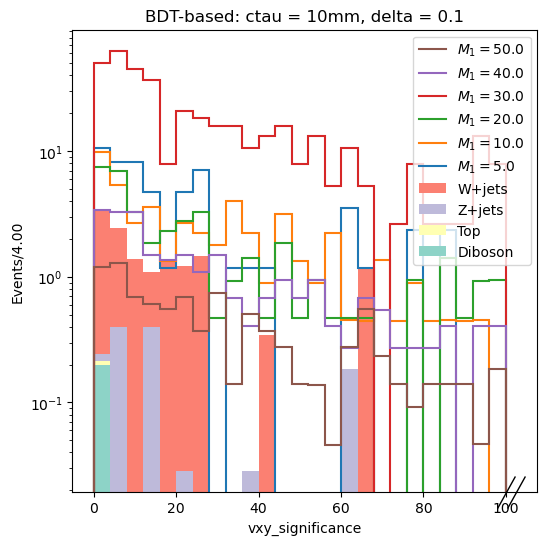

In [121]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=10.0

rebin = 4j

plt.title('BDT-based: ctau = 10mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut10', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

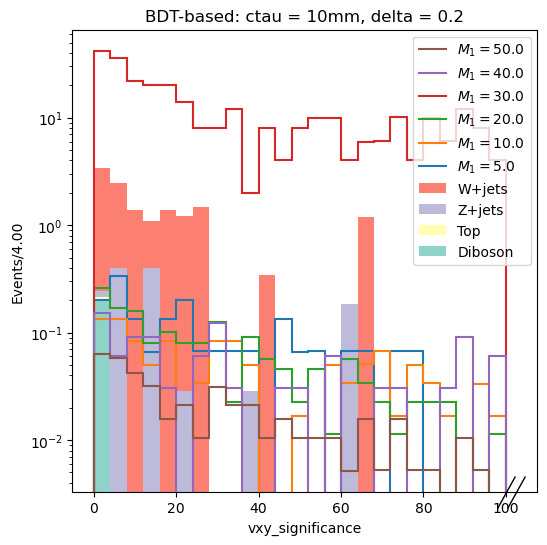

In [122]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=10.0

rebin = 4j

plt.title('BDT-based: ctau = 10mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut10', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

### BDTv2 ctau-100

In [139]:
prefix = '../SR_BDT-based/BDTv2_per_ctau/coffea/skimmed/'
suffix = '_SR_BDTv2_ctau-100_5to50_skimmed'

# Signal
f_sig = "signal"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD after OSSF cut
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

In [140]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
print(sig_samples)

['sig_2018_Mchi-5p5_dMchi-1p0_ctau-100', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-100', 'sig_2018_Mchi-5p25_dMchi-0p5_ctau-100', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100', 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-100', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-100', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-100', 'sig_2018_Mchi-11p0_dMchi-2p0_ctau-100', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-100']


In [141]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
print(cuts)

['all', 'hasVtx', 'cut5', 'cut6', 'cut7', 'cut8', 'cut9', 'cut10']


In [142]:
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

print(si)

                                         mchi  dmchi   ctau    m1    m2  \
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100     5.50    1.0  100.0   5.0   6.0   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100  55.00   10.0  100.0  50.0  60.0   
sig_2018_Mchi-5p25_dMchi-0p5_ctau-100    5.25    0.5  100.0   5.0   5.5   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100   52.50    5.0  100.0  50.0  55.0   
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100   44.00    8.0  100.0  40.0  48.0   
sig_2018_Mchi-33p0_dMchi-6p0_ctau-100   33.00    6.0  100.0  30.0  36.0   
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100   42.00    4.0  100.0  40.0  44.0   
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100   31.50    3.0  100.0  30.0  33.0   
sig_2018_Mchi-22p0_dMchi-4p0_ctau-100   22.00    4.0  100.0  20.0  24.0   
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100   21.00    2.0  100.0  20.0  22.0   
sig_2018_Mchi-11p0_dMchi-2p0_ctau-100   11.00    2.0  100.0  10.0  12.0   
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100   10.50    1.0  100.0  10.0  11.0   

                        

In [143]:
deltas = sorted(list(set(si.delta)))
m1s = sorted(list(set(si.m1)))
all_ctaus = sorted(list(set(si.ctau)))

In [144]:
bkg = {}

for h in histograms:
    bkg[h] = {}
    for b in bkg_histos.keys():
        if type(bkg_histos[b][h]) == hist.Hist and bkg_histos[b][h].sum(flow=True).value > 0:
            bkg[h][b] = bkg_histos[b][h][{"samp":sum}]

def plot_bkg(hname, cut, rebin=1j, doLog=True, xlim = [], title='', doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    plt.title(title)
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

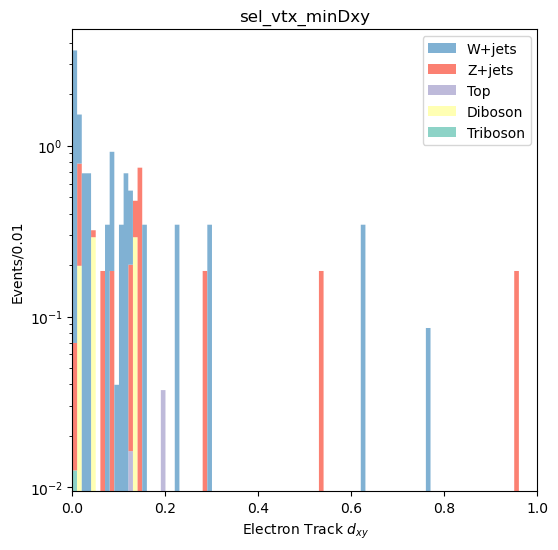

In [145]:
plot_bkg('sel_vtx_minDxy', 'cut10', xlim = [0, 1], title='sel_vtx_minDxy', rebin=1j)

In [146]:
def plot_sig(hname, cut, delta, m1, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
    hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
    mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

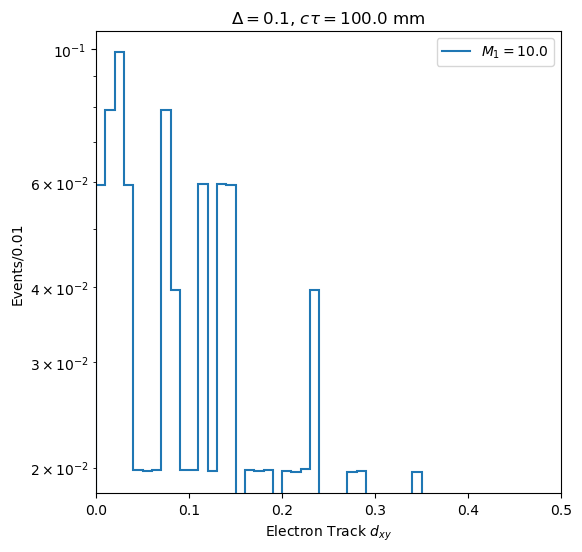

In [147]:
delta = deltas[0]
m1 = m1s[1]
ct = all_ctaus[0]

plot_sig('sel_vtx_minDxy', cut='cut10', xlim = [0, 0.5], delta=delta, m1=m1, ct=ct)

In [148]:
def plot_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel('Events/{:.2f}'.format(binwidth))
    if doLog:
        plt.yscale('log')
    plt.legend()

    if xlim != []:
        plt.xlim(xlim)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

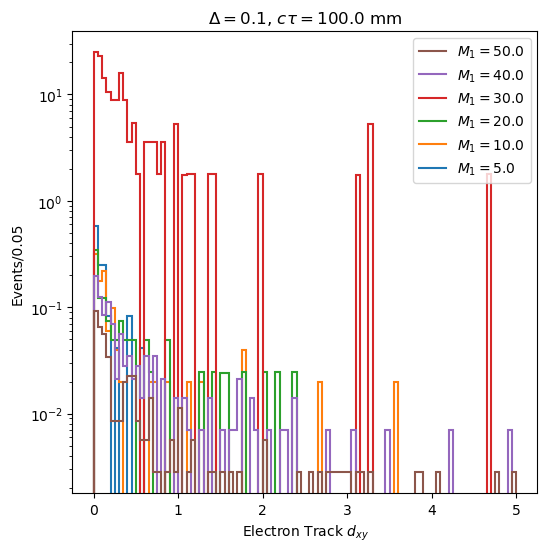

In [149]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, rebin=5j)

In [150]:
def plot_bkg_sig_varying_M1(ax, hname, cut, delta, ct, rebin=1j, xlim = [], xlabel='', flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):    
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.sca(ax)
    
    # bkg
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}

    nb = len(bkg_stack.keys())
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    # signal
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    #plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel('Events/{:.2f}'.format(binwidth))

    if xlabel != '':
        plt.xlabel(xlabel)
    
    if doLog:
        plt.yscale('log')
    plt.legend()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')

    if xlim != []:
        plt.xlim(xlim)
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}', bbox_inches='tight')
        print(f'Saved: {outDir}/{outName}')

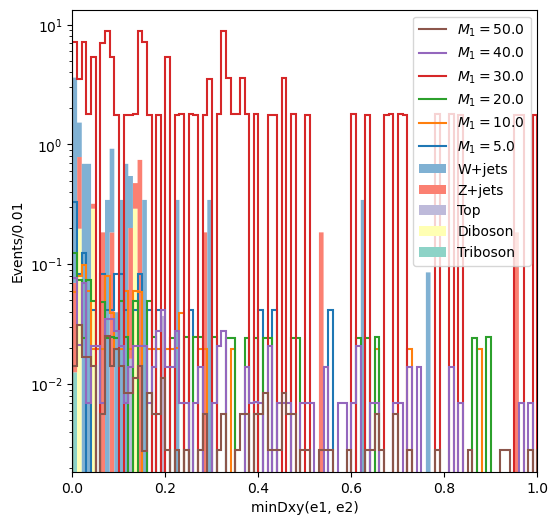

In [151]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, rebin=1j, xlim=[0,1], xlabel = 'minDxy(e1, e2)', doLog=True)

'sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif'

### 'sel_vtx_sign'

Text(0.5, 1.0, 'BDT-based: ctau = 100mm, delta = 0.1')

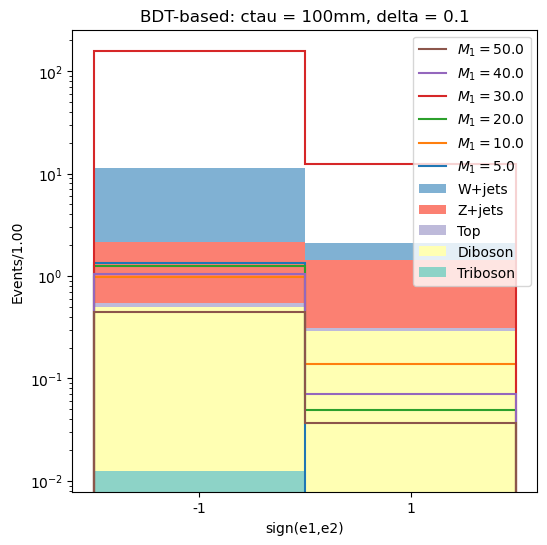

In [154]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut10', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('BDT-based: ctau = 100mm, delta = 0.1')

Text(0.5, 1.0, 'BDT-based: ctau = 100mm, delta = 0.2')

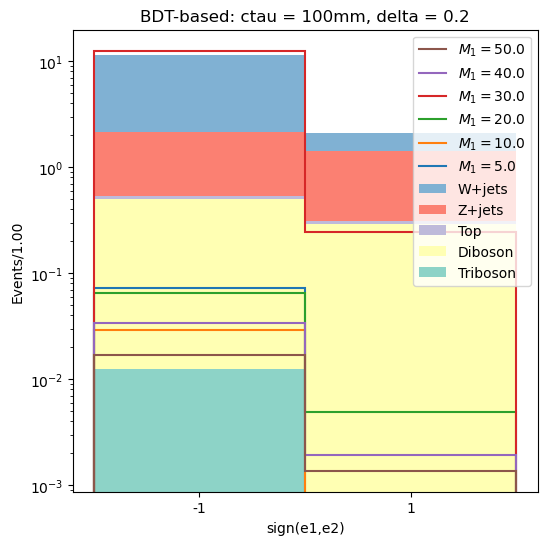

In [155]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

plot_bkg_sig_varying_M1(ax, 'sel_vtx_sign', 'cut10', delta, ct, rebin=1j, xlabel = 'sign(e1,e2)', doLog=True)

plt.title('BDT-based: ctau = 100mm, delta = 0.2')

### 'sel_vtx_METdPhi'

Text(0.5, 1.0, 'BDT-based: ctau = 100mm, delta = 0.1')

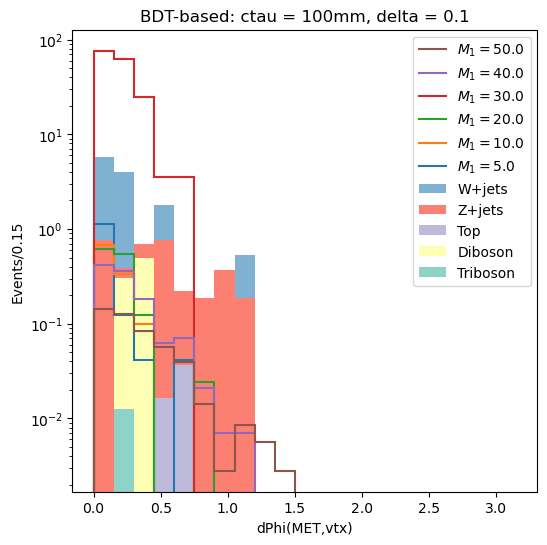

In [156]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.1
ct=100.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut10', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('BDT-based: ctau = 100mm, delta = 0.1')

Text(0.5, 1.0, 'BDT-based: ctau = 100mm, delta = 0.2')

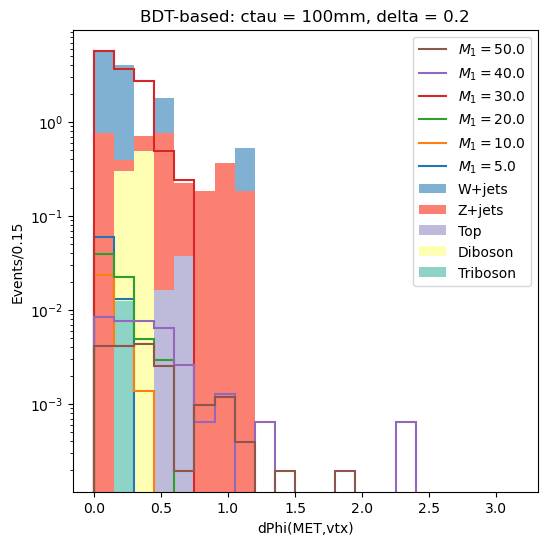

In [157]:
fig,ax = plt.subplots(1,1,figsize=(6,6))


delta=0.2
ct=100.0

rebin = 3j

plot_bkg_sig_varying_M1(ax, 'vtx_met_dPhi', 'cut10', delta, ct, rebin=rebin, xlabel = 'dPhi(MET,vtx)', doLog=True)

plt.title('BDT-based: ctau = 100mm, delta = 0.2')

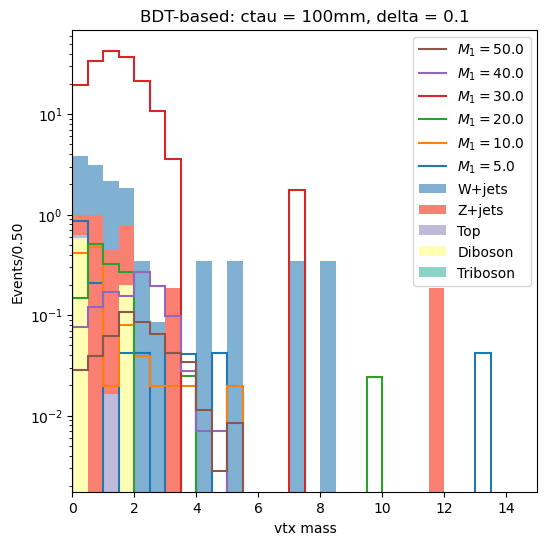

In [158]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 1j

plt.title('BDT-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut10', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

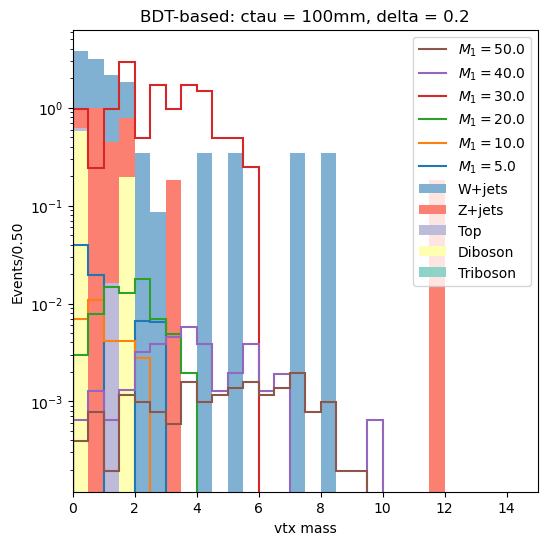

In [159]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 1j

plt.title('BDT-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_mass', 'cut10', delta, ct, xlim = [0, 15], rebin=rebin, xlabel = 'vtx mass', doLog=True)

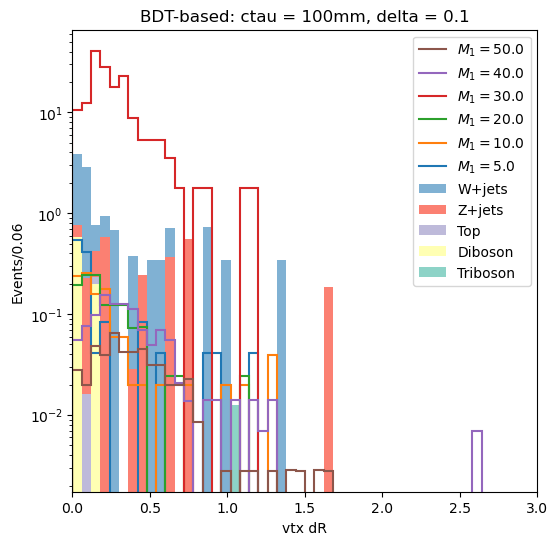

In [160]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 1j

plt.title('BDT-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx dR', doLog=True)

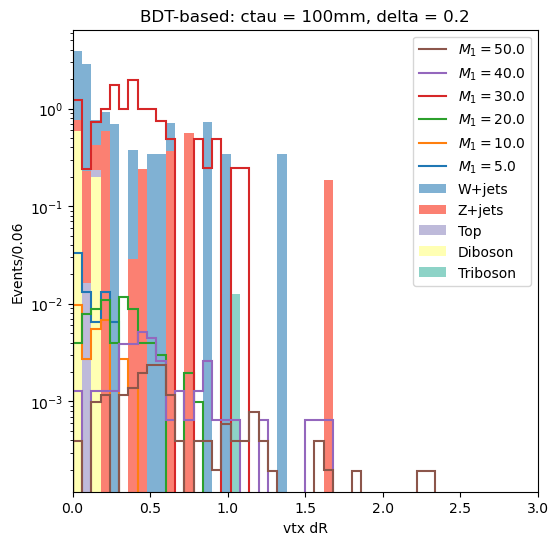

In [161]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 1j

plt.title('BDT-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,3], rebin=rebin, xlabel = 'vtx dR', doLog=True)

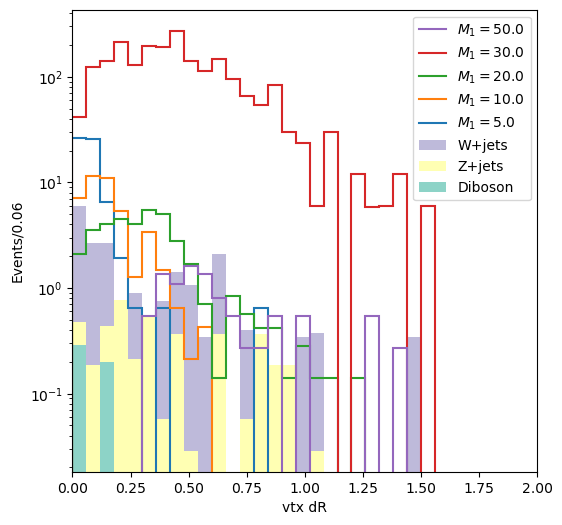

In [75]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

plot_bkg_sig_varying_M1(ax, 'sel_vtx_dR', 'cut10', delta, ct, xlim=[0,2], rebin=1j, xlabel = 'vtx dR', doLog=True)

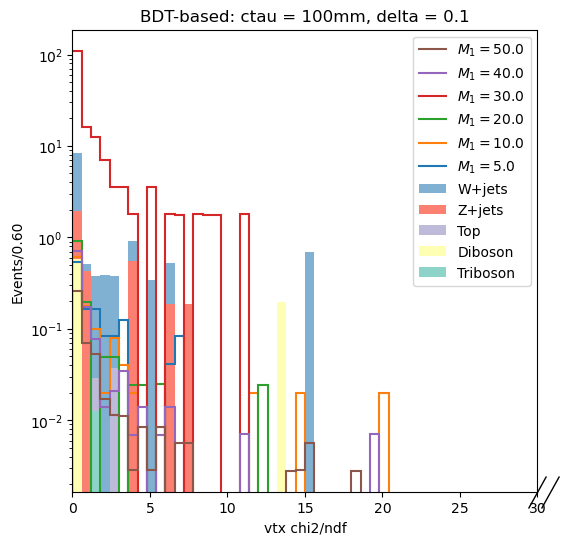

In [162]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 3j

plt.title('BDT-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut10', delta, ct, xlim=[0,30], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

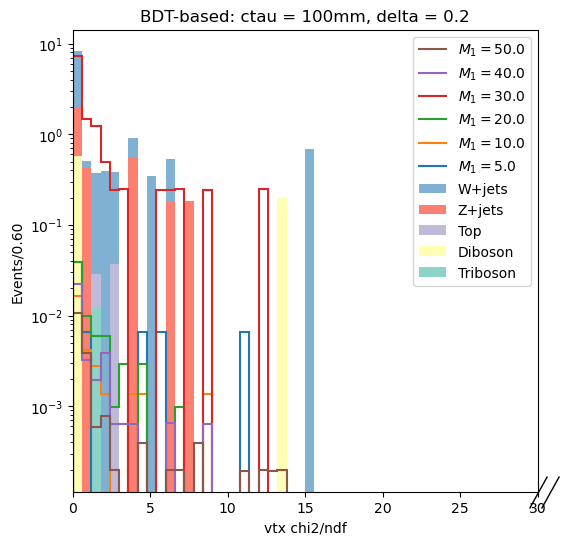

In [163]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 3j

plt.title('BDT-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_chi2', 'cut10', delta, ct, xlim=[0,30], rebin=rebin, xlabel = 'vtx chi2/ndf', doLog=True)

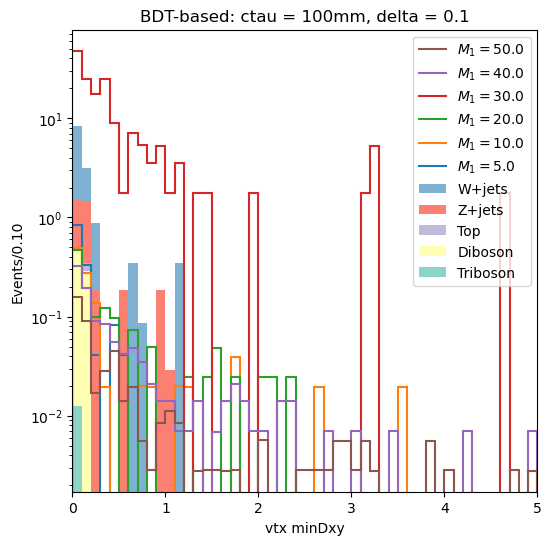

In [170]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 10j

plt.title('BDT-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, xlim=[0,5], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

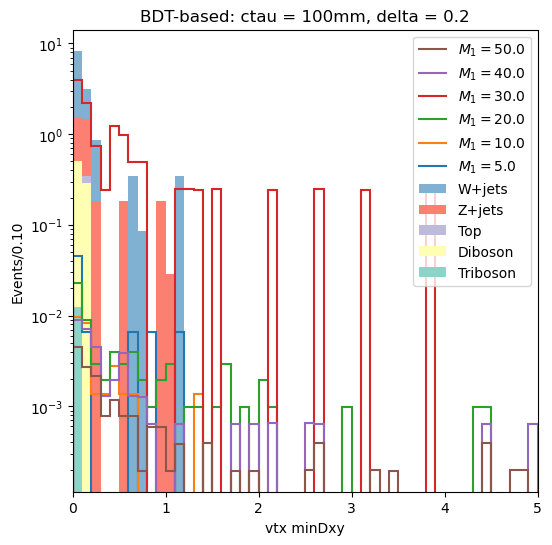

In [169]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 10j

plt.title('BDT-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_minDxy', 'cut10', delta, ct, xlim=[0,5], rebin=rebin, xlabel = 'vtx minDxy', doLog=True)

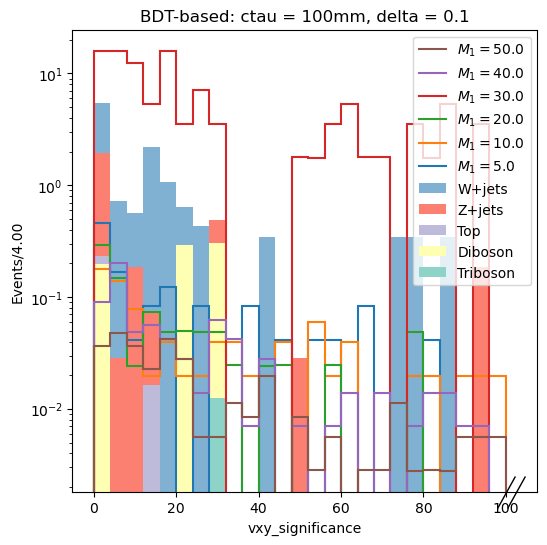

In [171]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.1
ct=100.0

rebin = 4j

plt.title('BDT-based: ctau = 100mm, delta = 0.1')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut10', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)

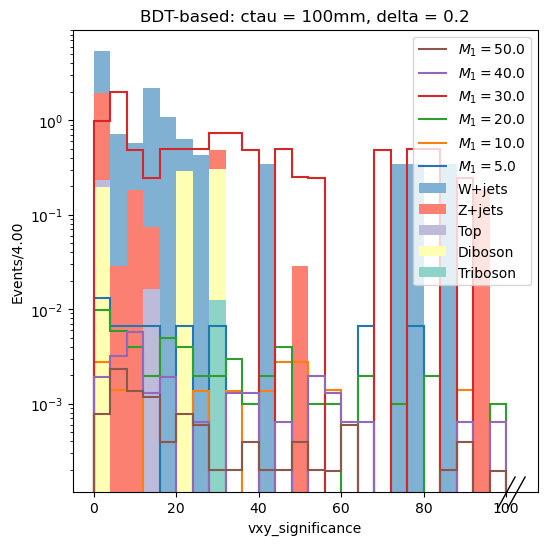

In [172]:
fig,ax = plt.subplots(1,1,figsize=(6,6))

delta=0.2
ct=100.0

rebin = 4j

plt.title('BDT-based: ctau = 100mm, delta = 0.2')

plot_bkg_sig_varying_M1(ax, 'sel_vtx_vxySignif', 'cut10', delta, ct, rebin=rebin, xlabel = 'vxy_significance', doLog=True)